<a href="https://colab.research.google.com/github/PrahasHegde/Particle_Filter_Main/blob/main/portfolio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ball Trajectory Estimation


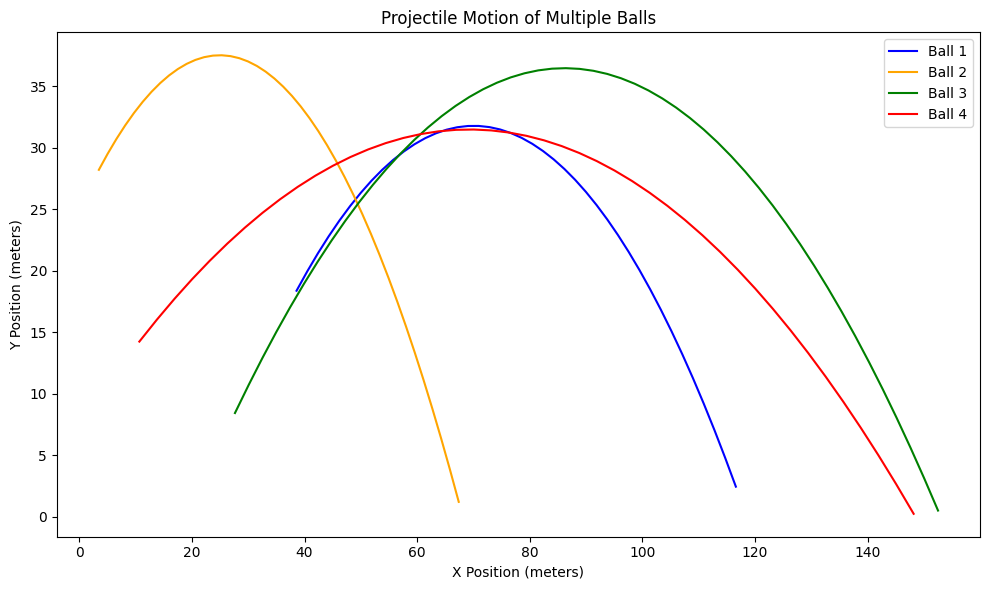

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ProjectileSimulation:
    def __init__(self, n_balls=4, num_steps=100, dt=0.1, g=9.81):
        """
        Initialize the simulation parameters.

        Args:
            n_balls (int): Number of balls to simulate.
            num_steps (int): Maximum time steps to simulate for each ball.
            dt (float): Time interval between each simulation step.
            g (float): Acceleration due to gravity (m/s^2).
        """
        self.n_balls = n_balls
        self.num_steps = num_steps
        self.dt = dt
        self.g = g
        self.trajectories = []  # To store the (x, y) positions of each ball

    def simulate_trajectory(self, x0, y0, v0, angle_deg):
        """
        Simulate the projectile motion of a single ball.

        Args:
            x0 (float): Initial x position.
            y0 (float): Initial y position.
            v0 (float): Initial velocity magnitude.
            angle_deg (float): Launch angle in degrees.

        Returns:
            Tuple of numpy arrays (x_positions, y_positions) representing the ball’s trajectory.
        """
        # Convert launch angle to radians for calculation
        angle_rad = np.deg2rad(angle_deg)
        # Calculate initial velocity components
        vx = v0 * np.cos(angle_rad)
        vy = v0 * np.sin(angle_rad)

        # Initialize position lists with the starting point
        x, y = [x0], [y0]
        for _ in range(self.num_steps):
            # Update vertical velocity by subtracting gravity effect
            vy -= self.g * self.dt
            # Calculate new positions based on velocity
            new_x = x[-1] + vx * self.dt
            new_y = y[-1] + vy * self.dt
            # Stop simulation if the ball hits the ground (y < 0)
            if new_y < 0:
                break
            # Append new positions to the trajectory
            x.append(new_x)
            y.append(new_y)

        return np.array(x), np.array(y)

    def run_simulation(self):
        """
        Run the full simulation for all balls with random initial conditions.
        """
        self.trajectories = []  # Clear any existing trajectories
        for _ in range(self.n_balls):
            # Randomly generate initial position, velocity, and angle for each ball
            x0 = np.random.uniform(0, 50)     # Start x somewhere between 0 and 50 meters
            y0 = np.random.uniform(0, 50)     # Start y somewhere between 0 and 50 meters
            v0 = np.random.uniform(20, 40)    # Initial speed between 20 and 40 m/s
            angle = np.random.uniform(30, 60) # Launch angle between 30 and 60 degrees

            # Simulate the trajectory for this ball
            x, y = self.simulate_trajectory(x0, y0, v0, angle)
            # Save the results
            self.trajectories.append((x, y))

    def plot_trajectories(self):
        """
        Plot the trajectories of all simulated balls using matplotlib.
        """
        colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']  # Colors for different balls
        plt.figure(figsize=(10, 6))

        # Plot each ball’s trajectory with a label and color
        for i, (x, y) in enumerate(self.trajectories):
            plt.plot(x, y, label=f"Ball {i+1}", color=colors[i % len(colors)])

        # Label the plot axes and title
        plt.xlabel("X Position (meters)")
        plt.ylabel("Y Position (meters)")
        plt.title("Projectile Motion of Multiple Balls")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Usage example:
sim = ProjectileSimulation(n_balls=4)  # Create simulation instance for 4 balls
sim.run_simulation()                   # Run simulation with random initial conditions
sim.plot_trajectories()                # Visualize the results


# Adding Noise to Ball Trajectory

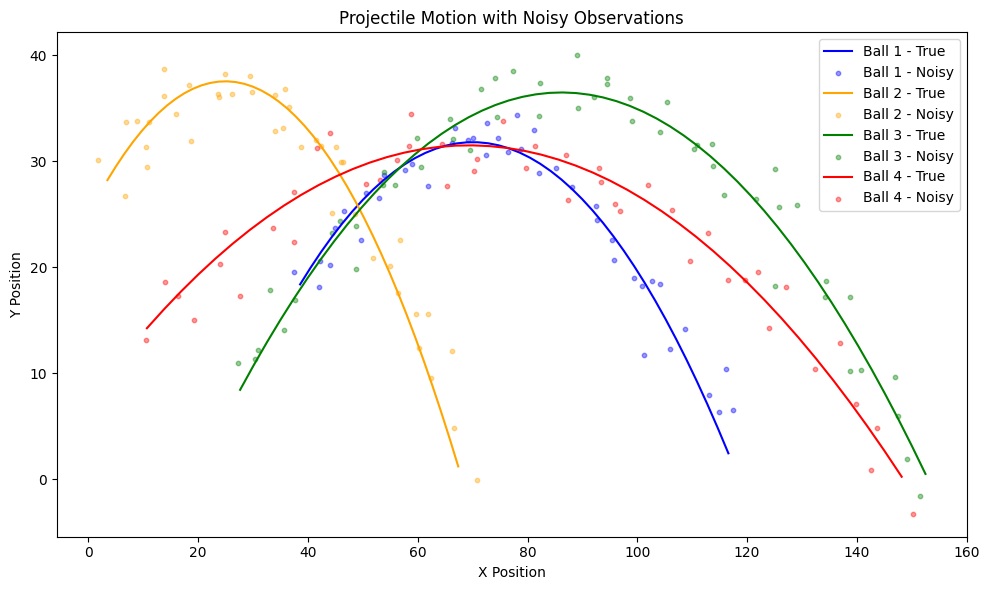

In [ ]:
# --- Noise-related configuration ---
noise_std = 2.0  # This defines how much Gaussian noise to add (higher = more noisy)
noisy_observations = []  # This will hold the noisy versions of each trajectory

# --- Function to add Gaussian noise to a trajectory ---
def add_noise(x, y, std):
    """
    Adds Gaussian noise to the given x and y coordinates.

    Args:
        x (np.array): Original x positions.
        y (np.array): Original y positions.
        std (float): Standard deviation of the noise to add.

    Returns:
        Tuple of (x_noisy, y_noisy): Noisy coordinates.
    """
    x_noisy = x + np.random.normal(0, std, size=x.shape)  # Add noise to x
    y_noisy = y + np.random.normal(0, std, size=y.shape)  # Add noise to y
    return x_noisy, y_noisy

# --- Add noise to each ball’s trajectory ---
for x, y in sim.trajectories:
    x_noisy, y_noisy = add_noise(x, y, noise_std)  # Add noise to current ball's trajectory
    noisy_observations.append((x_noisy, y_noisy))  # Store the noisy trajectory

# --- Visualize both the true and noisy trajectories together ---
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']  # Colors for the different balls
plt.figure(figsize=(10, 6))

# Plot each ball’s true and noisy path
for i, ((x_true, y_true), (x_noisy, y_noisy)) in enumerate(zip(sim.trajectories, noisy_observations)):
    color = colors[i % len(colors)]
    plt.plot(x_true, y_true, label=f"Ball {i+1} - True", color=color)        # Plot true trajectory (smooth line)
    plt.scatter(x_noisy, y_noisy, s=10, alpha=0.4, color=color,              # Plot noisy trajectory (scattered dots)
                label=f"Ball {i+1} - Noisy")

# Label the plot and add legend
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Projectile Motion with Noisy Observations")
plt.legend()
plt.tight_layout()
plt.show()


#Particle Filter to Track Ball Motion (Main)



/tmp/ipython-input-11-3734883818.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', self.n_balls)


Ball 1 RMSE (up to landing): 0.41
Ball 2 RMSE (up to landing): 0.44
Ball 3 RMSE (up to landing): 1.71
Ball 4 RMSE (up to landing): 0.38


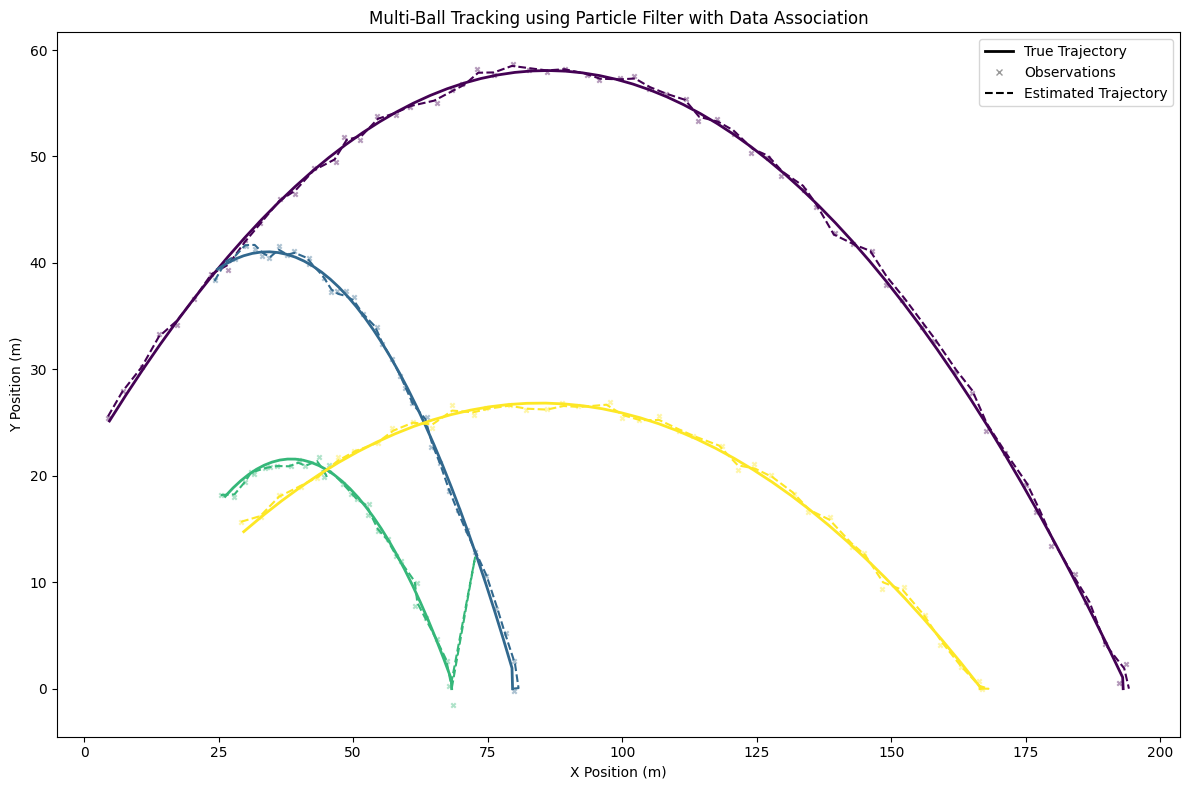

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


# Constants
g = 9.81  # Gravity in m/s^2
dt = 0.1  # Time interval between updates
num_particles = 20000  # Number of particles in the filter
num_steps = 100  # Max number of time steps to simulate
noise_std = 0.5  # Observation noise standard deviation

# Ball object that simulates projectile motion and generates noisy observations
class Ball:
    def __init__(self, x0, y0, v0, angle_deg):
        self.x0 = x0
        self.y0 = y0
        self.v0 = v0
        self.angle_deg = angle_deg
        self.angle_rad = np.deg2rad(angle_deg)
        self.vx0 = v0 * np.cos(self.angle_rad)
        self.vy0 = v0 * np.sin(self.angle_rad)
        self.x_true, self.y_true = self._simulate_trajectory()
        self.x_obs, self.y_obs = self._add_noise()

    def _simulate_trajectory(self):
        x, y = [self.x0], [self.y0]
        vx, vy = self.vx0, self.vy0

        for _ in range(num_steps):
            vy -= g * dt
            x_new = x[-1] + vx * dt
            y_new = y[-1] + vy * dt

            if y_new < 0:
                if y[-1] > 0:
                    fraction = -y[-1] / (vy - g * dt)
                    x_new = x[-1] + vx * dt * fraction
                y_new = 0.0
                x.append(x_new)
                y.append(y_new)
                break

            x.append(x_new)
            y.append(y_new)

        return np.array(x), np.array(y)

    def _add_noise(self):
        x_obs = self.x_true + np.random.normal(0, noise_std, size=self.x_true.shape)
        y_obs = self.y_true + np.random.normal(0, noise_std, size=self.y_true.shape)
        return x_obs, y_obs



# Particle Filter
# -------------------------------
# This class uses a particle filter to track multiple moving balls.
# Instead of assigning one filter per object, it shares particles across all and clusters them later.

class ParticleFilter:
    def __init__(self, num_particles, x0_range, y0_range, vx_range, vy_range):
        self.n = num_particles  # Total number of particles we’ll simulate.

        # Each particle is a possible guess about an object's position and velocity.
        # We initialize all of them randomly within the given range.
        self.particles = self._init_particles(x0_range, y0_range, vx_range, vy_range)

        # Initially, all particles are equally likely — so we give them equal weights.
        self.weights = np.ones(self.n) / self.n

    def _init_particles(self, x0_range, y0_range, vx_range, vy_range):
        p = np.empty((self.n, 4))  # Each particle holds [x, y, vx, vy]

        # Randomly assign starting values within the provided ranges
        p[:, 0] = np.random.uniform(*x0_range, size=self.n)  # Starting x position
        p[:, 1] = np.random.uniform(*y0_range, size=self.n)  # Starting y position
        p[:, 2] = np.random.uniform(*vx_range, size=self.n)  # Initial horizontal velocity
        p[:, 3] = np.random.uniform(*vy_range, size=self.n)  # Initial vertical velocity
        return p

    def predict(self):
        # Move each particle forward using basic physics (no air resistance).
        self.particles[:, 0] += self.particles[:, 2] * dt  # Update x: x += vx * dt
        self.particles[:, 1] += self.particles[:, 3] * dt  # Update y: y += vy * dt
        self.particles[:, 3] -= g * dt  # Apply gravity: vy -= g * dt

        # Add some random noise so particles can spread out and recover from errors.
        # The amount of noise adapts based on how confident the filter is.
        self.particles += np.random.normal(0, self.adaptive_noise(), self.particles.shape)

        # If any particle falls below the ground (y < 0), snap it to ground level.
        self.particles[self.particles[:, 1] < 0, 1] = 0.0

    def adaptive_noise(self):
        # We measure how spread out the weights are using entropy.
        # High entropy → uncertainty → more noise. Low entropy → confidence → less noise.
        entropy = -np.sum(self.weights * np.log(self.weights + 1e-10))
        max_entropy = np.log(self.n)

        # Scale the noise accordingly. We make sure there’s always a small base level of noise.
        return 0.05 + 0.5 * (entropy / max_entropy)

    def update(self, observations):
        # Compare each particle’s position to each observed data point (from the sensor).
        obs_array = np.array(observations)

        # Calculate distances between every particle and every observation.
        dists = np.linalg.norm(self.particles[:, None, :2] - obs_array[None, :, :], axis=2)

        # For each particle, we take the distance to its nearest observation.
        min_dists = np.min(dists, axis=1)

        # Particles closer to any observation get higher likelihood (weight).
        weights = np.exp(-min_dists**2 / (2 * noise_std**2))

        # You can "sharpen" the weight distribution by adjusting the power.
        weights = np.power(weights, 0.9)

        # Normalize the weights to sum up to 1.
        self.weights = weights / (np.sum(weights) + 1e-10)

    def resample(self):
        # Resample particles based on their weights so that better guesses get copied more.
        # This method helps the filter avoid focusing on bad particles.

        positions = (np.arange(self.n) + np.random.rand()) / self.n  # Systematic positions
        indexes = np.zeros(self.n, dtype=int)
        cumulative_sum = np.cumsum(self.weights)

        i, j = 0, 0
        while i < self.n:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1

        # Replace particles with the resampled ones and reset weights.
        self.particles = self.particles[indexes]
        self.weights = np.ones(self.n) / self.n

    def estimate_clusters(self, n_clusters):
        # We use clustering (KMeans) to find where the actual objects are likely to be.
        # The more confident we are about a particle, the more it influences the result.
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        kmeans.fit(self.particles[:, :2], sample_weight=self.weights)
        return kmeans.cluster_centers_  # Returns the estimated object positions.



# Simulator
# -------------------------------
# This class manages the entire simulation process.
# Initializes multiple balls with random initial states.
# Runs a particle filter to track their positions.
# Matches estimated positions to true observations.
# Visualizes the results.
class Simulator:
    def __init__(self, n_balls):
        self.n_balls = n_balls  # Number of balls to simulate and track
        self.balls = []  # Holds all Ball objects
        self.estimates_raw = [[] for _ in range(n_balls)]  # Raw position estimates from the particle filter
        self.estimates_processed_for_plot = [[] for _ in range(n_balls)]  # Estimates cleaned up for plotting

    def run(self):
        #np.random.seed(52)  # or any integer seed you want
        # Generate each ball with random starting positions, speeds, and angles
        for _ in range(self.n_balls):
            ball = Ball(
                x0=np.random.uniform(0, 50),
                y0=np.random.uniform(0, 50),
                v0=np.random.uniform(15, 50),
                angle_deg=np.random.uniform(15, 60)
            )
            self.balls.append(ball)

        # Determine how long we need to run the simulation (based on the longest ball flight)
        max_timesteps = max(len(ball.x_obs) for ball in self.balls)

        # Set up initial ranges for particles so they cover possible states of all balls
        x0_range = (min(ball.x0 for ball in self.balls) - 5, max(ball.x0 for ball in self.balls) + 5)
        y0_range = (0, max(ball.y0 for ball in self.balls) + 10)
        vx_range = (0, max(ball.vx0 for ball in self.balls) + 5)
        vy_range = (min(ball.vy0 for ball in self.balls) - 10, max(ball.vy0 for ball in self.balls) + 5)

        pf = ParticleFilter(num_particles, x0_range, y0_range, vx_range, vy_range)


        # Main Simulation Loop
        for t in range(max_timesteps):
            pf.predict()  # Move all particles forward one step

            current_obs = []
            for ball in self.balls:
                if t < len(ball.x_obs):
                    # If ball is still in the air, record its observation
                    current_obs.append((ball.x_obs[t], ball.y_obs[t]))
                else:
                    # If it has landed, repeat the last observed position
                    current_obs.append((ball.x_obs[-1], ball.y_obs[-1]))

            pf.update(current_obs)  # Adjust particle weights based on how close they are to the current observations

            # Estimate the actual object positions by clustering the particles
            estimated_centers = pf.estimate_clusters(n_clusters=self.n_balls)




            # Associate Estimated Positions with Real Balls
            # K-Means doesn't label clusters. We match each estimate to the correct ball using the Hungarian algorithm.
            cost_matrix = np.linalg.norm(np.array(current_obs)[:, None, :] - estimated_centers[None, :, :], axis=2)
            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            # Save the correctly matched estimates
            for obs_idx, center_idx in zip(row_ind, col_ind):
                self.estimates_raw[obs_idx].append(estimated_centers[center_idx])

            pf.resample()  # Resample particles based on updated weights



        # Post-Process Estimates for Plotting
        for i, ball in enumerate(self.balls):
            true_trajectory_len = len(ball.x_true)
            processed_est_traj = []

            for t_step in range(max_timesteps):
                if t_step < true_trajectory_len:
                    # Keep the estimated position while the ball is in the air
                    processed_est_traj.append(self.estimates_raw[i][t_step])
                else:
                    # Once it lands, keep x fixed and set y to 0
                    last_true_x = ball.x_true[-1]
                    processed_est_traj.append([last_true_x, 0.0])

            self.estimates_processed_for_plot[i] = np.array(processed_est_traj)

    def plot(self):
        plt.figure(figsize=(12, 8))  # Set up the plot window

        # Assign a unique color to each ball
        colors = plt.cm.get_cmap('viridis', self.n_balls)

        for i, ball in enumerate(self.balls):
            ball_true_traj = np.column_stack((ball.x_true, ball.y_true))
            ball_obs_traj = np.column_stack((ball.x_obs, ball.y_obs))
            ball_est_traj_plot = self.estimates_processed_for_plot[i]

            # Plot the actual path (solid line)
            plt.plot(ball_true_traj[:, 0], ball_true_traj[:, 1], color=colors(i),
                     linestyle='-', linewidth=2, label=f'Ball {i+1} True Trajectory' if i == 0 else "")

            # Plot the noisy observations (scatter 'x')
            plt.scatter(ball_obs_traj[:, 0], ball_obs_traj[:, 1], s=10, alpha=0.4,
                        color=colors(i), marker='x', label=f'Ball {i+1} Observations' if i == 0 else "")

            # Plot the estimated path (dashed line)
            plt.plot(ball_est_traj_plot[:, 0], ball_est_traj_plot[:, 1], color=colors(i),
                     linestyle='--', linewidth=1.5, label=f'Ball {i+1} Estimated Trajectory' if i == 0 else "")

            # Compute RMSE (only while the ball was flying)
            min_len = min(len(ball_true_traj), len(ball_est_traj_plot))
            rmse = np.sqrt(mean_squared_error(ball_true_traj[:min_len], ball_est_traj_plot[:min_len]))
            print(f"Ball {i+1} RMSE (up to landing): {rmse:.2f}")

        # Add axis labels and title
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.title('Multi-Ball Tracking using Particle Filter with Data Association')

        # Combine legend entries to avoid repetition
        custom_lines = [
            Line2D([0], [0], color='black', lw=2, linestyle='-'),                      # True trajectory
            Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=5, alpha=0.4),  # Observations
            Line2D([0], [0], color='black', lw=1.5, linestyle='--')                    # Estimated trajectory
        ]
        plt.legend(custom_lines, ['True Trajectory', 'Observations', 'Estimated Trajectory'])

        plt.tight_layout()
        plt.show()



# Run the Simulation
# -------------------------------
if __name__ == "__main__":
    # Initialize and run a simulation tracking 5 separate balls
    sim = Simulator(n_balls=4)
    sim.run()   # Run the simulation
    sim.plot()  # Display the results


## Introducing Dropout in Particle Filter

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Constants
g = 9.81 #Acceleration due to gravity(m/s^2)
dt = 0.1 #Time step
num_particles = 20000
num_steps = 100 # Max steps for simulation, actual steps depend on when y < 0
noise_std = 0.5 # Standard deviation of observation noise



# Ball class to simulate and store trajectory
#--------------------------------------------
class Ball:
    def __init__(self, x0, y0, v0, angle_deg):
        self.x0 = x0
        self.y0 = y0
        self.v0 = v0
        self.angle_deg = angle_deg
        self.angle_rad = np.deg2rad(angle_deg)
        self.vx0 = v0 * np.cos(self.angle_rad)# Initial velocity in x
        self.vy0 = v0 * np.sin(self.angle_rad)# Initial velocity in y

        # Simulate the trajectory and generate noisy observations
        self.x_true, self.y_true = self._simulate_trajectory()
        self.x_obs, self.y_obs = self._add_noise()

    def _simulate_trajectory(self):
        # Generate ground truth (noiseless) trajectory using basic kinematics
        x, y = [self.x0], [self.y0]
        vx, vy = self.vx0, self.vy0
        for _ in range(num_steps):
            vy -= g * dt
            x_new = x[-1] + vx * dt
            y_new = y[-1] + vy * dt
            if y_new < 0:
                if y[-1] > 0:
                    # Interpolate to find exact ground hit
                    fraction = -y[-1] / (vy - g * dt)
                    x_new = x[-1] + vx * dt * fraction
                y_new = 0.0
                x.append(x_new)
                y.append(y_new)
                break
            x.append(x_new)
            y.append(y_new)
        return np.array(x), np.array(y)

    def _add_noise(self):
        # Add Gaussian noise to the true trajectory to simulate sensor noise
        x_obs = self.x_true + np.random.normal(0, noise_std, size=self.x_true.shape)
        y_obs = self.y_true + np.random.normal(0, noise_std, size=self.y_true.shape)
        return x_obs, y_obs


# Particle Filter
#----------------
class ParticleFilter:
    def __init__(self, num_particles, x0_range, y0_range, vx_range, vy_range, n_tracked_objects):
        self.n = num_particles
        self.particles = self._init_particles(x0_range, y0_range, vx_range, vy_range)
        self.weights = np.ones(self.n) / self.n # Initialize weights
        self.n_tracked_objects = n_tracked_objects # Store the number of objects we expect to track
        self.n_eff_history = [] # To store effective number of particles

    def _init_particles(self, x0_range, y0_range, vx_range, vy_range):
        p = np.empty((self.n, 4))
        p[:, 0] = np.random.uniform(*x0_range, size=self.n)
        p[:, 1] = np.random.uniform(*y0_range, size=self.n)
        p[:, 2] = np.random.uniform(*vx_range, size=self.n)
        p[:, 3] = np.random.uniform(*vy_range, size=self.n)
        return p

    def predict(self):
        self.particles[:, 0] += self.particles[:, 2] * dt
        self.particles[:, 1] += self.particles[:, 3] * dt
        self.particles[:, 3] -= g * dt

        # Add adaptive noise
        noise_levels = self.adaptive_noise()
        self.particles += np.random.normal(0, noise_levels, self.particles.shape)

        # Ensure particles don't go below ground
        self.particles[self.particles[:, 1] < 0, 1] = 0.0

    def adaptive_noise(self):
        # Avoid log(0) by adding a small epsilon
        entropy = -np.sum(self.weights * np.log(self.weights + 1e-10))
        max_entropy = np.log(self.n)

        # Handle case where max_entropy might be very small or zero (e.g., n=1)
        normalized_entropy = entropy / (max_entropy + 1e-10)

        # Base noise for position and velocity components
        base_pos_noise = 0.05
        base_vel_noise = 0.02

        # Additional noise based on uncertainty (entropy)
        additional_pos_noise = 0.5 * normalized_entropy
        additional_vel_noise = 0.2 * normalized_entropy

        # Return an array of shape (4,) for [x, y, vx, vy] noise
        return np.array([base_pos_noise + additional_pos_noise,
                         base_pos_noise + additional_pos_noise,
                         base_vel_noise + additional_vel_noise,
                         base_vel_noise + additional_vel_noise])

    def update(self, observations):
        # Convert list of tuples to numpy array once for efficiency
        obs_array = np.array(observations)

        if obs_array.shape[0] > 0: # Check if there are any observations
            # Calculate distance from each particle to each observation
            # particles[:, None, :2] creates (n_particles, 1, 2)
            # obs_array[None, :, :] creates (1, n_observations, 2)
            # Resulting diff array is (n_particles, n_observations, 2)
            dists = np.linalg.norm(self.particles[:, None, :2] - obs_array[None, :, :], axis=2)

            # Find the minimum distance from each particle to any observation
            min_dists = np.min(dists, axis=1)

            # Calculate weights based on these minimum distances
            weights = np.exp(-min_dists**2 / (2 * noise_std**2))

            # Normalize weights
            sum_weights = np.sum(weights)
            if sum_weights > 1e-10: # Avoid division by zero
                self.weights = weights / sum_weights
            else:
                self.weights = np.ones(self.n) / self.n # Reset to uniform if all weights are tiny
        # If no observations, weights are NOT updated; they remain uniform from resampling or previous step.

        # Calculate and store N_eff
        sum_of_squared_weights = np.sum(np.square(self.weights))
        N_eff = 1.0 / sum_of_squared_weights if sum_of_squared_weights > 1e-10 else 0
        self.n_eff_history.append(N_eff)


    def resample(self):
        # Systematic Resampling
        # Handle case where weights might sum to zero (e.g., after a prolonged dropout with no effective particles)
        if np.sum(self.weights) < 1e-10:
            self.weights = np.ones(self.n) / self.n # Reset to uniform weights if they are all zero

        positions = (np.arange(self.n) + np.random.rand()) / self.n
        indexes = np.zeros(self.n, dtype=int)
        cumulative_sum = np.cumsum(self.weights)
        i, j = 0, 0
        while i < self.n:
            # Ensure j does not go out of bounds for cumulative_sum
            # This check is more robust, but j should naturally stop at n-1 if positions[i] keeps increasing
            # and cumulative_sum reaches 1.0
            if j >= self.n:
                j = self.n - 1

            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        self.particles = self.particles[indexes]
        self.weights = np.ones(self.n) / self.n


    def estimate_clusters(self, n_observations_present):
        # If no observations were made, we assume the targets are in their last estimated positions,
        # or we use the overall weighted mean of particles as a fallback.
        if n_observations_present == 0:
            if np.sum(self.weights) < 1e-10:
                # If weights are all zero, take a simple mean (or last known estimates from Simulator)
                weighted_mean_pos = np.mean(self.particles[:,:2], axis=0)
            else:
                weighted_mean_pos = np.average(self.particles[:, :2], axis=0, weights=self.weights)
            return np.array([weighted_mean_pos] * self.n_tracked_objects)

        # Determine how many clusters KMeans should try to find
        # Cap clusters by the number of active observations and unique particle positions.
        unique_particles_pos = np.unique(self.particles[:,:2], axis=0)
        num_clusters_for_kmeans = min(self.n_tracked_objects, n_observations_present, len(unique_particles_pos))

        # Ensure at least one cluster if there are particles
        if num_clusters_for_kmeans == 0 and len(unique_particles_pos) > 0:
            num_clusters_for_kmeans = 1
        elif num_clusters_for_kmeans == 0: # If no unique particles either, return replicated mean
            weighted_mean_pos = np.average(self.particles[:, :2], axis=0, weights=self.weights) if np.sum(self.weights) > 1e-10 else np.mean(self.particles[:,:2], axis=0)
            return np.array([weighted_mean_pos] * self.n_tracked_objects)


        try:
            # Use `max_iter` for robustness, n_init for better convergence
            kmeans = KMeans(n_clusters=num_clusters_for_kmeans, n_init=10, random_state=42, max_iter=300)
            kmeans.fit(self.particles[:, :2], sample_weight=self.weights)
            centers = kmeans.cluster_centers_

            # If fewer clusters are found than tracked objects, pad with duplicates (or last known positions)
            while len(centers) < self.n_tracked_objects:
                centers = np.vstack([centers, centers[0]]) # Simple padding, can be improved with more sophisticated logic

            # If more clusters are found than tracked objects (shouldn't happen with min() above, but for safety)
            if len(centers) > self.n_tracked_objects:
                centers = centers[:self.n_tracked_objects]

            return centers

        except Exception as e:
            # Fallback if KMeans fails for any reason
            # print(f"KMeans clustering failed: {e}. Falling back to weighted mean for all objects.")
            if np.sum(self.weights) < 1e-10:
                weighted_mean_pos = np.mean(self.particles[:,:2], axis=0)
            else:
                weighted_mean_pos = np.average(self.particles[:, :2], axis=0, weights=self.weights)
            return np.array([weighted_mean_pos] * self.n_tracked_objects)



# Simulator
#----------------
class Simulator:
    def __init__(self, n_balls, dropout_probability=0.3, dropout_duration_steps_min=5, dropout_duration_steps_max=20):
        self.n_balls = n_balls
        self.balls = []
        self.estimates_raw = [[] for _ in range(n_balls)]
        self.estimates_processed_for_plot = [[] for _ in range(n_balls)]
        self.error_history = [[] for _ in range(n_balls)] # To store error over time
        self.dropout_probability = dropout_probability
        self.dropout_duration_steps_min = dropout_duration_steps_min
        self.dropout_duration_steps_max = dropout_duration_steps_max
        self.global_dropout_interval = None
        self.n_eff_history_pf = [] # To store N_eff from particle filter
        self.max_timesteps = 0
        self.time_axis = None

    def _generate_global_dropout_interval(self, max_timesteps):
        if np.random.rand() < self.dropout_probability:
            min_start_t = int(max_timesteps * 0.1)
            max_possible_start_t = max_timesteps - self.dropout_duration_steps_min - 1

            if max_possible_start_t <= min_start_t:
                # Not enough room for a dropout
                return

            start_t = np.random.randint(min_start_t, max_possible_start_t + 1)
            duration = np.random.randint(self.dropout_duration_steps_min, self.dropout_duration_steps_max + 1)
            end_t = min(start_t + duration, max_timesteps - 1)

            self.global_dropout_interval = (start_t, end_t)
            print(f"Global sensor dropout: from step {start_t} to {end_t}")


    def run(self):
        # Initialize balls and ranges
        initial_x = []
        initial_y = []
        initial_vx = []
        initial_vy = []

        for _ in range(self.n_balls):
            ball = Ball(
                x0=np.random.uniform(0, 50),
                y0=np.random.uniform(0, 50),
                v0=np.random.uniform(15, 50),
                angle_deg=np.random.uniform(15, 60)
            )
            self.balls.append(ball)
            initial_x.append(ball.x0)
            initial_y.append(ball.y0)
            initial_vx.append(ball.vx0)
            initial_vy.append(ball.vy0)


        self.max_timesteps = max(len(ball.x_obs) for ball in self.balls)
        self.time_axis = np.arange(self.max_timesteps) * dt # Convert steps to time
        self._generate_global_dropout_interval(self.max_timesteps)

        # Define particle filter ranges based on initial ball properties
        x0_range = (min(initial_x) - 5, max(initial_x) + 5)
        y0_range = (0, max(initial_y) + 10)
        vx_range = (0, max(initial_vx) + 5)
        vy_range = (min(initial_vy) - 10, max(initial_vy) + 5)

        pf = ParticleFilter(num_particles, x0_range, y0_range, vx_range, vy_range, self.n_balls)

        # Prepare for storing last known estimates for smooth tracking during dropouts
        last_known_estimates = [np.array([ball.x0, ball.y0]) for ball in self.balls]

        # Track whether a dropout is active at each timestep for plotting
        self.is_dropout_active_at_t = [False] * self.max_timesteps

        for t in range(self.max_timesteps):
            pf.predict()

            is_global_dropout_active = False
            if self.global_dropout_interval:
                start_t_dropout, end_t_dropout = self.global_dropout_interval
                if start_t_dropout <= t <= end_t_dropout:
                    is_global_dropout_active = True

            self.is_dropout_active_at_t[t] = is_global_dropout_active # Store for plotting

            current_obs = []
            active_ball_indices = []

            if not is_global_dropout_active:
                for i, ball in enumerate(self.balls):
                    if t < len(ball.x_obs):
                        current_obs.append((ball.x_obs[t], ball.y_obs[t]))
                        active_ball_indices.append(i)
                    # If ball has landed but not in dropout, we still "observe" it at its landing spot
                    elif t >= len(ball.x_obs):
                        current_obs.append((ball.x_true[-1], 0.0))
                        active_ball_indices.append(i)


            pf.update(current_obs)
            # Ensure n_eff_history_pf is populated, even if pf.n_eff_history might be empty initially
            if pf.n_eff_history:
                self.n_eff_history_pf.append(pf.n_eff_history[-1])
            else:
                self.n_eff_history_pf.append(0) # Or some default value if no N_eff calculated yet


            estimated_centers = pf.estimate_clusters(len(current_obs))

            # Map estimated centers to actual balls
            current_timestep_estimates = [None] * self.n_balls

            if len(current_obs) > 0 and len(estimated_centers) > 0:
                cost_matrix = np.linalg.norm(np.array(current_obs)[:, None, :2] - estimated_centers[None, :, :2], axis=2)
                row_ind, col_ind = linear_sum_assignment(cost_matrix)

                for obs_idx, center_idx in zip(row_ind, col_ind):
                    original_ball_idx = active_ball_indices[obs_idx]
                    current_timestep_estimates[original_ball_idx] = estimated_centers[center_idx]

            # Fill in missing estimates (e.g., during dropout or if no observation for a ball)
            for k in range(self.n_balls):
                if current_timestep_estimates[k] is not None:
                    last_known_estimates[k] = current_timestep_estimates[k] # Update last known estimate
                else:
                    # If no new estimate, use the last known estimate
                    current_timestep_estimates[k] = last_known_estimates[k]

                self.estimates_raw[k].append(current_timestep_estimates[k])

                # Calculate error for this step
                true_pos = np.array([self.balls[k].x_true[min(t, len(self.balls[k].x_true) - 1)],
                                     self.balls[k].y_true[min(t, len(self.balls[k].y_true) - 1)]])
                estimated_pos = np.array(current_timestep_estimates[k])
                self.error_history[k].append(np.linalg.norm(true_pos - estimated_pos))

            pf.resample()

        # Post-process raw estimates to make them stop at y=0 when the true ball lands
        for i, ball in enumerate(self.balls):
            true_trajectory_len = len(ball.x_true)
            processed_est_traj = []

            for t_step in range(self.max_timesteps):
                current_raw_estimate = self.estimates_raw[i][t_step]

                if t_step < true_trajectory_len:
                    processed_est_traj.append(current_raw_estimate)
                else:
                    # If true ball has landed, force estimated y to 0 and x to landed x
                    processed_est_traj.append([ball.x_true[-1], 0.0])

            self.estimates_processed_for_plot[i] = np.array(processed_est_traj)


    def plot_xy_trajectories(self):
        colors = plt.cm.get_cmap('viridis', self.n_balls)
        fig, ax = plt.subplots(figsize=(10, 7))

        # Calculate the bounding box for the dropout period in X-Y plane
        if self.global_dropout_interval:
            start_t_dropout, end_t_dropout = self.global_dropout_interval

            all_x_in_dropout = []
            all_y_in_dropout = []

            for ball in self.balls:
                # Ensure the time steps are within the bounds of the ball's true trajectory
                safe_start_t = min(start_t_dropout, len(ball.x_true) - 1)
                safe_end_t = min(end_t_dropout, len(ball.x_true) - 1)

                if safe_start_t <= safe_end_t:
                    all_x_in_dropout.extend(ball.x_true[safe_start_t : safe_end_t + 1])
                    all_y_in_dropout.extend(ball.y_true[safe_start_t : safe_end_t + 1])

            if all_x_in_dropout and all_y_in_dropout:
                min_x_dropout = min(all_x_in_dropout)
                max_x_dropout = max(all_x_in_dropout)
                min_y_dropout = min(all_y_in_dropout)
                max_y_dropout = max(all_y_in_dropout)

                # Add the shaded area
                ax.axvspan(min_x_dropout, max_x_dropout, color='gray', alpha=0.2, lw=0, label='Global Sensor Dropout')


        has_labeled_dropout_segment = False # To add 'Estimated (Dropout)' to legend only once

        for i, ball in enumerate(self.balls):
            ball_true_traj = np.column_stack((ball.x_true, ball.y_true))
            ball_est_traj_plot = self.estimates_processed_for_plot[i]

            ax.plot(ball_true_traj[:, 0], ball_true_traj[:, 1], color=colors(i),
                        linestyle='-', linewidth=2, label=f'Ball {i+1} True Trajectory')

            valid_obs_x = []
            valid_obs_y = []
            for t_step in range(len(ball.x_obs)):
                is_global_dropout_active_at_t = False
                if self.global_dropout_interval:
                    start_t_dropout, end_t_dropout = self.global_dropout_interval
                    if start_t_dropout <= t_step <= end_t_dropout:
                        is_global_dropout_active_at_t = True
                if not is_global_dropout_active_at_t:
                    valid_obs_x.append(ball.x_obs[t_step])
                    valid_obs_y.append(ball.y_obs[t_step])

            ax.scatter(valid_obs_x, valid_obs_y, s=10, alpha=0.4,
                         color=colors(i), marker='x', label=f'Ball {i+1} Observations')

            # Plot estimated trajectory. Break into segments if dropout occurs.
            if self.global_dropout_interval:
                start_t_dropout, end_t_dropout = self.global_dropout_interval

                # Segment before dropout
                if start_t_dropout > 0:
                    ax.plot(ball_est_traj_plot[:start_t_dropout+1, 0], ball_est_traj_plot[:start_t_dropout+1, 1],
                             color=colors(i), linestyle='--', linewidth=1.5)

                # Segment during dropout
                if start_t_dropout <= end_t_dropout and end_t_dropout < len(ball_est_traj_plot):
                    dropout_segment = ball_est_traj_plot[start_t_dropout:end_t_dropout+1]
                    # Only add label once for the legend
                    label_dropout_segment = 'Estimated Trajectory (Dropout)' if not has_labeled_dropout_segment else None
                    ax.plot(dropout_segment[:, 0], dropout_segment[:, 1],
                             color=colors(i), linestyle=':', linewidth=1.5, label=label_dropout_segment) # Use dotted for dropout
                    has_labeled_dropout_segment = True

                # Segment after dropout
                if end_t_dropout + 1 < len(ball_est_traj_plot):
                    ax.plot(ball_est_traj_plot[end_t_dropout+1:, 0], ball_est_traj_plot[end_t_dropout+1:, 1],
                             color=colors(i), linestyle='--', linewidth=1.5)
            else:
                # No dropout, plot entire estimated trajectory normally
                ax.plot(ball_est_traj_plot[:, 0], ball_est_traj_plot[:, 1],
                         color=colors(i), linestyle='--', linewidth=1.5, label=f'Ball {i+1} Estimated Trajectory')

            min_len = min(len(ball_true_traj), len(ball_est_traj_plot))
            rmse = np.sqrt(mean_squared_error(ball_true_traj[:min_len], ball_est_traj_plot[:min_len]))
            print(f"Ball {i+1} RMSE (up to landing): {rmse:.2f}")

        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title('Multi-Ball Tracking with Global Sensor Dropout (X-Y Plane)')

        # Create custom handles for the legend to avoid duplicate labels for each ball
        custom_lines_xy = [
            Line2D([0], [0], color='black', lw=2, linestyle='-'),
            Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=5, alpha=0.4),
            Line2D([0], [0], color='black', lw=1.5, linestyle='--'),
            Line2D([0], [0], color='black', lw=1.5, linestyle=':'), # New line for dropout segment
            Line2D([0], [0], color='gray', lw=8, alpha=0.2) # New line for the dropout region
        ]
        # Adjust legend labels
        ax.legend(custom_lines_xy, ['True Trajectory', 'Observations', 'Estimated Trajectory', 'Estimated (Dropout)', 'Global Sensor Dropout'], loc='upper left')
        ax.grid(True)
        fig.tight_layout()
        return fig, ax


    def plot_x_vs_time(self):
        colors = plt.cm.get_cmap('viridis', self.n_balls)
        fig, ax = plt.subplots(figsize=(10, 7))

        for i, ball in enumerate(self.balls):
            ax.plot(self.time_axis[:len(ball.x_true)], ball.x_true, color=colors(i), linestyle='-', label=f'Ball {i+1} True X')

            valid_obs_x_t = []
            valid_times_x_t = []
            for t_step in range(len(ball.x_obs)):
                is_global_dropout_active_at_t = False
                if self.global_dropout_interval:
                    start_t_dropout, end_t_dropout = self.global_dropout_interval
                    if start_t_dropout <= t_step <= end_t_dropout:
                        is_global_dropout_active_at_t = True
                if not is_global_dropout_active_at_t:
                    valid_obs_x_t.append(ball.x_obs[t_step])
                    valid_times_x_t.append(t_step * dt)
            ax.scatter(valid_times_x_t, valid_obs_x_t, s=10, alpha=0.4, color=colors(i), marker='x', label=f'Ball {i+1} Obs X')

            # Plot estimated trajectory (X component)
            if self.global_dropout_interval:
                start_t_dropout, end_t_dropout = self.global_dropout_interval

                # Segment before dropout
                if start_t_dropout > 0:
                    ax.plot(self.time_axis[:start_t_dropout+1], self.estimates_processed_for_plot[i][:start_t_dropout+1, 0],
                             color=colors(i), linestyle='--', linewidth=1.5)

                # Segment during dropout
                if start_t_dropout <= end_t_dropout and end_t_dropout < len(self.estimates_processed_for_plot[i]):
                    ax.plot(self.time_axis[start_t_dropout:end_t_dropout+1], self.estimates_processed_for_plot[i][start_t_dropout:end_t_dropout+1, 0],
                             color=colors(i), linestyle=':', linewidth=1.5) # Use dotted for dropout

                # Segment after dropout
                if end_t_dropout + 1 < len(self.estimates_processed_for_plot[i]):
                    ax.plot(self.time_axis[end_t_dropout+1:len(self.estimates_processed_for_plot[i])], self.estimates_processed_for_plot[i][end_t_dropout+1:, 0],
                             color=colors(i), linestyle='--', linewidth=1.5)
            else:
                ax.plot(self.time_axis[:len(self.estimates_processed_for_plot[i])], self.estimates_processed_for_plot[i][:, 0],
                        color=colors(i), linestyle='--', label=f'Ball {i+1} Est X')

        if self.global_dropout_interval:
            start_t_dropout, end_t_dropout = self.global_dropout_interval
            ax.axvspan(start_t_dropout * dt, end_t_dropout * dt, color='gray', alpha=0.2, lw=0, label='Global Sensor Dropout')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('X Position')
        ax.set_title('X Position vs Time')

        # Custom legend for this plot
        custom_lines_x_t = [
            Line2D([0], [0], color='black', lw=2, linestyle='-'),
            Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=5, alpha=0.4),
            Line2D([0], [0], color='black', lw=1.5, linestyle='--'),
            Line2D([0], [0], color='black', lw=1.5, linestyle=':'), # New line for dropout segment
            Line2D([0], [0], color='grey', lw=8, alpha=0.2)
        ]
        # Only show a single legend entry for each type of line, not for each ball
        ax.legend(custom_lines_x_t, ['True X', 'Observed X', 'Estimated X', 'Estimated X (Dropout)', 'Global Sensor Dropout'], loc='upper left')
        ax.grid(True)
        fig.tight_layout()
        return fig, ax


    def plot_y_vs_time(self):
        colors = plt.cm.get_cmap('viridis', self.n_balls)
        fig, ax = plt.subplots(figsize=(10, 7))

        for i, ball in enumerate(self.balls):
            ax.plot(self.time_axis[:len(ball.y_true)], ball.y_true, color=colors(i), linestyle='-', label=f'Ball {i+1} True Y')

            valid_obs_y_t = []
            valid_times_y_t = []
            for t_step in range(len(ball.y_obs)):
                is_global_dropout_active_at_t = False
                if self.global_dropout_interval:
                    start_t_dropout, end_t_dropout = self.global_dropout_interval
                    if start_t_dropout <= t_step <= end_t_dropout:
                        is_global_dropout_active_at_t = True
                if not is_global_dropout_active_at_t:
                    valid_obs_y_t.append(ball.y_obs[t_step])
                    valid_times_y_t.append(t_step * dt)
            ax.scatter(valid_times_y_t, valid_obs_y_t, s=10, alpha=0.4, color=colors(i), marker='x', label=f'Ball {i+1} Obs Y')

            # Plot estimated trajectory (Y component)
            if self.global_dropout_interval:
                start_t_dropout, end_t_dropout = self.global_dropout_interval

                # Segment before dropout
                if start_t_dropout > 0:
                    ax.plot(self.time_axis[:start_t_dropout+1], self.estimates_processed_for_plot[i][:start_t_dropout+1, 1],
                             color=colors(i), linestyle='--', linewidth=1.5)

                # Segment during dropout
                if start_t_dropout <= end_t_dropout and end_t_dropout < len(self.estimates_processed_for_plot[i]):
                    ax.plot(self.time_axis[start_t_dropout:end_t_dropout+1], self.estimates_processed_for_plot[i][start_t_dropout:end_t_dropout+1, 1],
                             color=colors(i), linestyle=':', linewidth=1.5) # Use dotted for dropout

                # Segment after dropout
                if end_t_dropout + 1 < len(self.estimates_processed_for_plot[i]):
                    ax.plot(self.time_axis[end_t_dropout+1:len(self.estimates_processed_for_plot[i])], self.estimates_processed_for_plot[i][end_t_dropout+1:],
                             color=colors(i), linestyle='--', linewidth=1.5)
            else:
                ax.plot(self.time_axis[:len(self.estimates_processed_for_plot[i])], self.estimates_processed_for_plot[i][:, 1],
                        color=colors(i), linestyle='--', label=f'Ball {i+1} Est Y')

        if self.global_dropout_interval:
            start_t_dropout, end_t_dropout = self.global_dropout_interval
            ax.axvspan(start_t_dropout * dt, end_t_dropout * dt, color='gray', alpha=0.2, lw=0, label='Global Sensor Dropout')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Y Position')
        ax.set_title('Y Position vs Time')

        # Custom legend for this plot
        custom_lines_y_t = [
            Line2D([0], [0], color='black', lw=2, linestyle='-'),
            Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=5, alpha=0.4),
            Line2D([0], [0], color='black', lw=1.5, linestyle='--'),
            Line2D([0], [0], color='black', lw=1.5, linestyle=':'), # New line for dropout segment
            Line2D([0], [0], color='grey', lw=8, alpha=0.2)
        ]
        # Only show a single legend entry for each type of line, not for each ball
        ax.legend(custom_lines_y_t, ['True Y', 'Observed Y', 'Estimated Y', 'Estimated Y (Dropout)', 'Global Sensor Dropout'], loc='upper left')
        ax.grid(True)
        fig.tight_layout()
        return fig, ax


    def plot_n_eff_vs_time(self):
        fig, ax = plt.subplots(figsize=(10, 7))

        ax.plot(self.time_axis[:len(self.n_eff_history_pf)], self.n_eff_history_pf, color='blue', label='Effective Number of Particles ($N_{eff}$)')
        ax.axhline(y=num_particles / 2, color='red', linestyle=':', label='$N/2$ Resampling Threshold')

        if self.global_dropout_interval:
            start_t_dropout, end_t_dropout = self.global_dropout_interval
            ax.axvspan(start_t_dropout * dt, end_t_dropout * dt, color='gray', alpha=0.2, lw=0, label='Global Sensor Dropout')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('$N_{eff}$')
        ax.set_title('Effective Number of Particles ($N_{eff}$) vs Time')
        ax.legend(loc='lower left')
        ax.set_ylim(0, num_particles + 1000) # Ensure y-axis shows full range
        ax.grid(True)
        fig.tight_layout()
        return fig, ax


    def plot_error_vs_time(self):
        colors = plt.cm.get_cmap('viridis', self.n_balls)
        fig, ax = plt.subplots(figsize=(10, 7))

        for i, ball in enumerate(self.balls):
            # Plot error trajectory. Break into segments if dropout occurs.
            if self.global_dropout_interval:
                start_t_dropout, end_t_dropout = self.global_dropout_interval

                # Segment before dropout
                if start_t_dropout > 0:
                    ax.plot(self.time_axis[:start_t_dropout+1], self.error_history[i][:start_t_dropout+1],
                             color=colors(i), linestyle='-', linewidth=1.5)

                # Segment during dropout
                if start_t_dropout <= end_t_dropout and end_t_dropout < len(self.error_history[i]):
                    ax.plot(self.time_axis[start_t_dropout:end_t_dropout+1], self.error_history[i][start_t_dropout:end_t_dropout+1],
                             color=colors(i), linestyle=':', linewidth=1.5) # Use dotted for dropout

                # Segment after dropout
                if end_t_dropout + 1 < len(self.error_history[i]):
                    ax.plot(self.time_axis[end_t_dropout+1:len(self.error_history[i])], self.error_history[i][end_t_dropout+1:],
                             color=colors(i), linestyle='-', linewidth=1.5)
            else:
                ax.plot(self.time_axis[:len(self.error_history[i])], self.error_history[i],
                        color=colors(i), linestyle='-', label=f'Ball {i+1} Error')

        if self.global_dropout_interval:
            start_t_dropout, end_t_dropout = self.global_dropout_interval
            ax.axvspan(start_t_dropout * dt, end_t_dropout * dt, color='gray', alpha=0.2, lw=0, label='Global Sensor Dropout')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Error (Euclidean Distance)')
        ax.set_title('Tracking Error vs Time')

        # Custom legend for this plot
        custom_lines_error = [
            Line2D([0], [0], color='black', lw=2, linestyle='-'),
            Line2D([0], [0], color='black', lw=1.5, linestyle=':'), # New line for dropout segment
            Line2D([0], [0], color='grey', lw=8, alpha=0.2)
        ]
        # Only show a single legend entry for 'Error' and 'Global Sensor Dropout'
        ax.legend(custom_lines_error, ['Individual Ball Error', 'Individual Ball Error (Dropout)', 'Global Sensor Dropout'], loc='upper left')

        ax.grid(True)
        fig.tight_layout()
        return fig, ax



# Run simulation
sim = Simulator(n_balls=3, dropout_probability=0.5, dropout_duration_steps_min=5, dropout_duration_steps_max=20)
sim.run()

Global sensor dropout: from step 54 to 68


## True vs Estimated Trajectory

/tmp/ipython-input-68-2958759511.py:365: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', self.n_balls)


Ball 1 RMSE (up to landing): 9.56
Ball 2 RMSE (up to landing): 8.94
Ball 3 RMSE (up to landing): 9.31


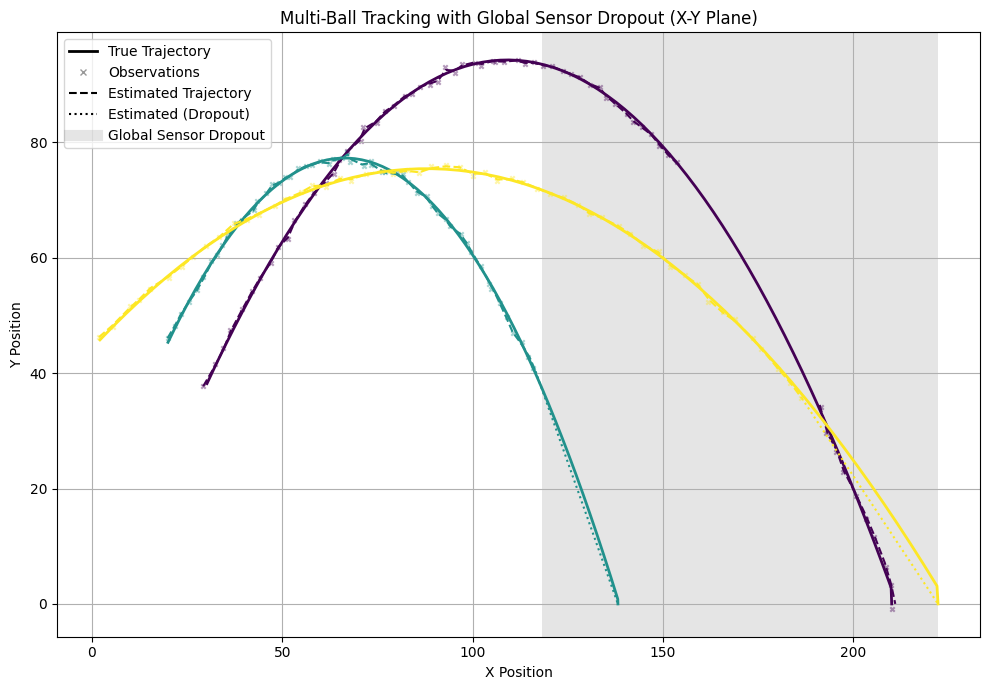

In [ ]:
# Plot X-Y trajectories
fig_xy, ax_xy = sim.plot_xy_trajectories()
plt.show(fig_xy)

## Position(x) vs time

/tmp/ipython-input-15-2958759511.py:469: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', self.n_balls)


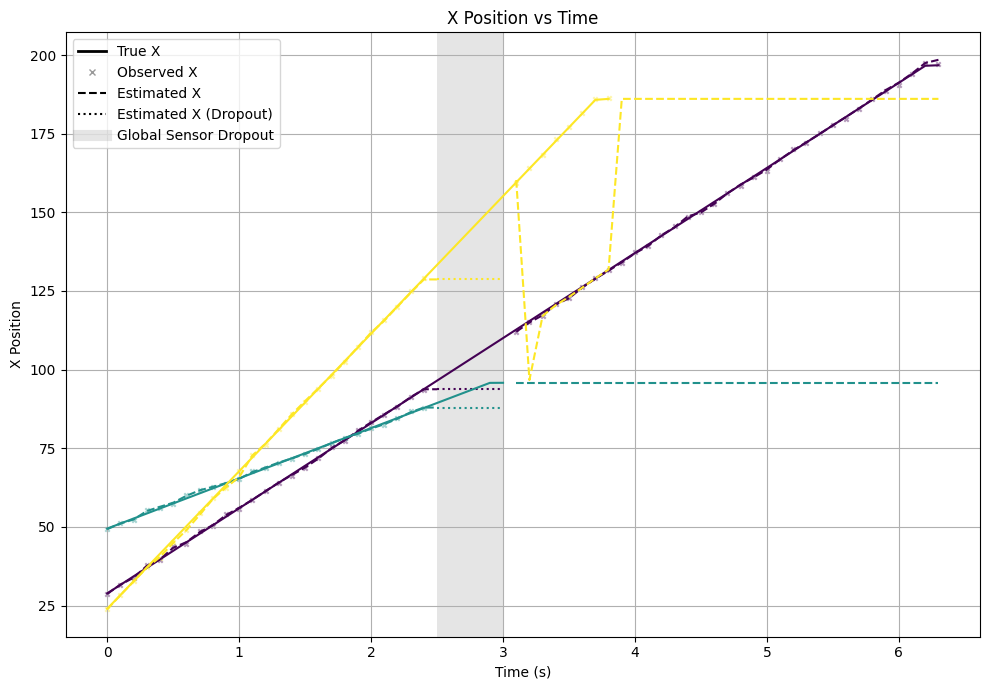

In [ ]:
# Plot X vs Time
fig_x_t, ax_x_t = sim.plot_x_vs_time()
plt.show(fig_x_t)

## Poaition(Y) vs Time

/tmp/ipython-input-51-2958759511.py:534: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', self.n_balls)


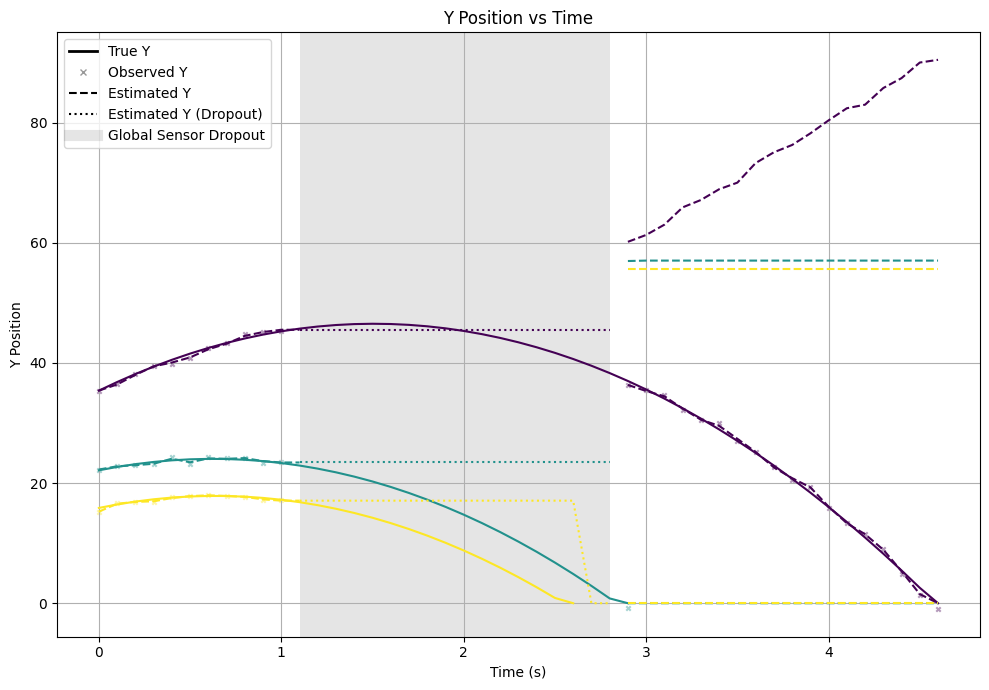

In [ ]:
# Plot Y vs Time
fig_y_t, ax_y_t = sim.plot_y_vs_time()
plt.show(fig_y_t)

## Resampling vs Time

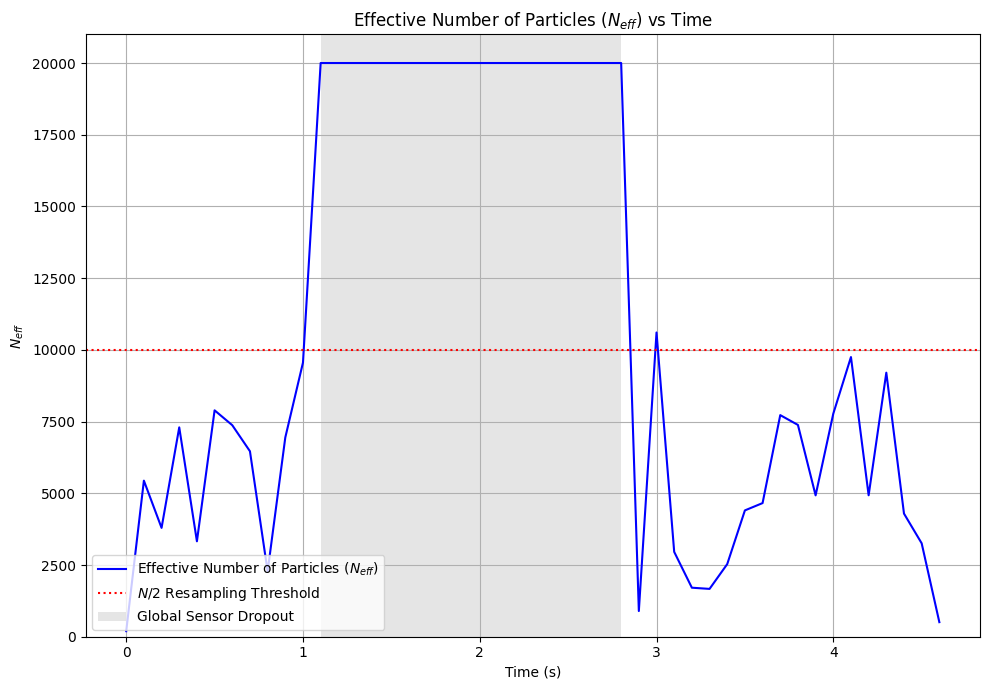

In [ ]:
# Plot N_eff vs Time
fig_n_eff, ax_n_eff = sim.plot_n_eff_vs_time()
plt.show(fig_n_eff)

##Error vs Time


/tmp/ipython-input-51-2958759511.py:619: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', self.n_balls)


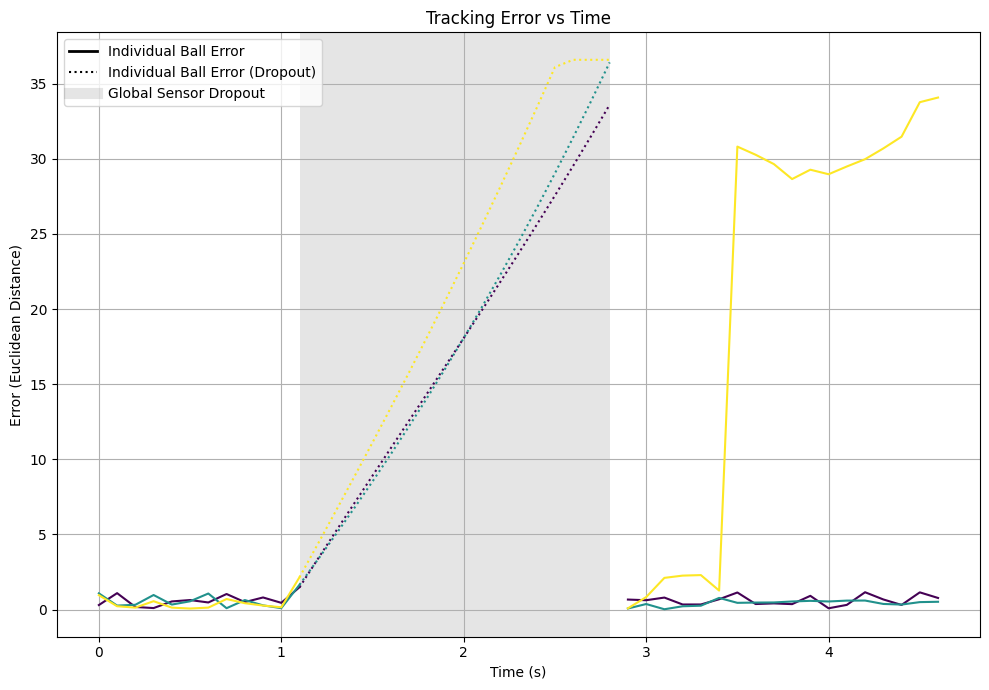

In [ ]:
# Plot Error vs Time
fig_error, ax_error = sim.plot_error_vs_time()
plt.show(fig_error)

#Particle Filter (Approach 2)

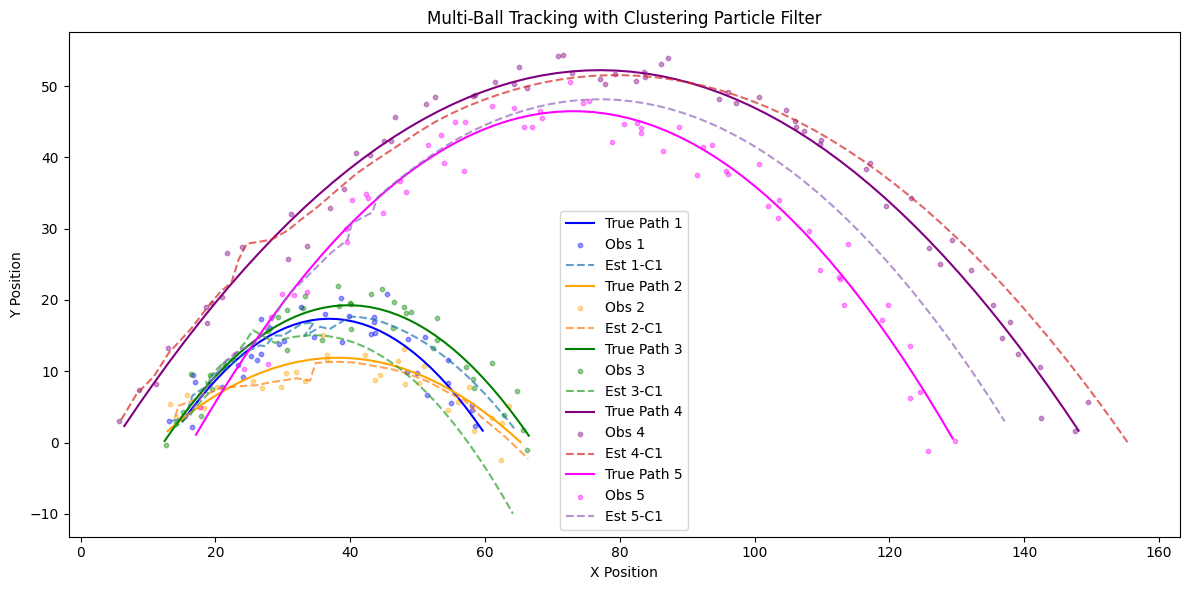

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



#Constants
g = 9.81  # Acceleration due to gravity (m/s^2)
dt = 0.1  # Time step (seconds)
num_particles = 1000 # Number of particles
num_steps = 100 # Maximum simulation steps for a ball's flight.
noise_std = 2.0 # Standard deviation of observation noise (meters).



# Ball Class: Our Flying Object
# -------------------------------
# This class represents a single projectile ball. It calculates its true path
# Generates noisy observation.

class Ball:
    def __init__(self, x0, y0, v0, angle_deg):
        # Store initial conditions for the ball.
        self.x0 = x0  # horizontal position.
        self.y0 = y0  # vertical position.
        self.v0 = v0  # launch speed.
        self.angle_deg = angle_deg # Launch angle in degrees.

        # Convert angle to radians.
        self.angle_rad = np.deg2rad(angle_deg)

        # Calculate initial velocity components.
        self.vx0 = v0 * np.cos(self.angle_rad)
        self.vy0 = v0 * np.sin(self.angle_rad)

        # Simulate the ball's true trajectory.
        self.x_true, self.y_true = self._simulate_trajectory()

        # Add realistic noise to the true trajectory to create observations.
        self.x_obs, self.y_obs = self._add_noise()

    def _simulate_trajectory(self):
        # Initialize lists to store the true x and y coordinates over time.
        x, y = [self.x0], [self.y0]
        # Initialize current velocities with their initial values.
        vx, vy = self.vx0, self.vy0

        # Loop through time steps to simulate the flight.
        for _ in range(num_steps):
            vy -= g * dt  # Gravity for vertical velocity.
            x_new = x[-1] + vx * dt # Horizontal position updates based on constant horizontal velocity.
            y_new = y[-1] + vy * dt # Vertical position updates based on vertical velocity.

            if y_new < 0: # If the ball goes below ground (y=0), it has landed.
                break

            x.append(x_new) # Add the new x-position to the trajectory.
            y.append(y_new) # Add the new y-position to the trajectory.

        # Convert lists to NumPy arrays for easy computation.
        return np.array(x), np.array(y)

    def _add_noise(self):
        # Generate noisy observations by adding random values
        x_obs = self.x_true + np.random.normal(0, noise_std, size=self.x_true.shape)
        y_obs = self.y_true + np.random.normal(0, noise_std, size=self.y_true.shape)
        return x_obs, y_obs # Return the noisy observed positions.



# Particle Filter
# -------------------------------
# This class implements a particle filter
class ParticleFilter:
    def __init__(self, num_particles, x0_range, y0_range, vx_range, vy_range, n_clusters=2):
        self.n = num_particles # Store the number of particles.
        self.n_clusters = n_clusters # How many distinct objects we expect K-Means to find.

        # Initialize particles:
        # They are randomly spread across the initial state space.
        self.particles = self._init_particles(x0_range, y0_range, vx_range, vy_range)

        # Initialize weights: initially, all particles are equally likely, so they have equal weights.
        self.weights = np.ones(self.n) / self.n

    def _init_particles(self, x0_range, y0_range, vx_range, vy_range):
        p = np.empty((self.n, 4)) # Create an array to hold all particle states: [x, y, vx, vy].
        # Fill each state component with random values within the specified ranges.
        p[:, 0] = np.random.uniform(*x0_range, size=self.n)  # Initial x position guesses.
        p[:, 1] = np.random.uniform(*y0_range, size=self.n)  # Initial y position guesses.
        p[:, 2] = np.random.uniform(*vx_range, size=self.n)  # Initial x-velocity guesses.
        p[:, 3] = np.random.uniform(*vy_range, size=self.n)  # Initial y-velocity guesses.
        return p

    def predict(self):
        # This is the "motion model" step. We move each particle forward in time as per physics.
        self.particles[:, 0] += self.particles[:, 2] * dt # Update x: x = x + vx * dt
        self.particles[:, 1] += self.particles[:, 3] * dt # Update y: y = y + vy * dt
        self.particles[:, 3] -= g * dt # Update vy: vy = vy - g * dt

    def update(self, obs):
        # This is the "update" step. We compare each particle's predicted position to the actual observation received from the sensor.

        # Calculate the Euclidean distance between each particle's position (x, y) and the single observation.
        distances = np.linalg.norm(self.particles[:, :2] - obs, axis=1)

        # Update weights: Particles that are closer to the observation get higher weights, they are more likely to represent the true state.
        # We use a Gaussian-like weighting function.
        self.weights = np.exp(-distances**2 / 4.0) # The '4.0' here acts like 2 * sigma^2, effectively scaling the "likelihood".

        self.weights += 1.e-300 # Add a number to prevent weights from becoming exactly zero.
        self.weights /= np.sum(self.weights) # Normalize weights so they sum to 1.

    def resample(self):

        """We create a new set of particles by picking from the current set, but with
        a probability proportional to their weights. Particles with higher weights
        are more likely to be duplicated, and low-weight particles are eliminated."""

        indices = np.random.choice(self.n, self.n, p=self.weights) # Choose 'n' particles based on their probabilities.
        self.particles = self.particles[indices] # Replace old particles with the newly selected ones.
        self.weights.fill(1.0 / self.n) # Reset all new particles to have equal weights.

    def estimate_clusters(self):
        # Use K-Means clustering to find the "center" of the particle cloud.
        # If tracking multiple objects, K-Means will naturally find multiple centers.
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=10) # Initialize K-Means with the expected number of clusters.

        kmeans.fit(self.particles[:, :2], sample_weight=self.weights)
        return kmeans.cluster_centers_ # Return the coordinates of the cluster centers.


W
# Simulator
# -------------------------------
# This class manages the entire simulation: creating balls, running the particle

class Simulator:
    def __init__(self, n_balls, n_clusters=2):
        self.n_balls = n_balls # How many balls to simulate.
        self.n_clusters = n_clusters # How many clusters the PF's K-Means should look for.
        self.balls = [] # List to hold all the Ball objects.
        self.estimates_all = [] # List to store the estimated positions from the particle filter for each ball.

    def run(self):
        # Create and initialize multiple balls with random starting conditions.
        for _ in range(self.n_balls):
            x0 = np.random.uniform(0, 50)  # Random initial x.
            y0 = np.random.uniform(0, 50)   # Random initial y.
            v0 = np.random.uniform(20, 40) # Random initial velocity.
            angle = np.random.uniform(30, 60) # Random launch angle.

            ball = Ball(x0, y0, v0, angle) # Create a new Ball object.
            self.balls.append(ball) # Add it to our list of balls.

            """Initialize a Particle Filter for THIS specific ball.
            Here, we're setting up 'n_balls' separate PFs, each designed to
            potentially see 'n_clusters' objects."""

            pf = ParticleFilter(
                num_particles,
                x0_range=(x0 - 5, x0 + 5), # Initial particle spread around the ball's actual x0.
                y0_range=(y0 - 5, y0 + 5), # Initial particle spread around the ball's actual y0.
                vx_range=(ball.vx0 - 5, ball.vx0 + 5), # Initial particle spread around the ball's actual vx0.
                vy_range=(ball.vy0 - 5, ball.vy0 + 5), # Initial particle spread around the ball's actual vy0.
                n_clusters=self.n_clusters # Tell this PF how many clusters to expect.
            )

            estimates = [] # List to store estimated cluster centers for this ball.
            # Loop through each time step where we have observations for this ball.
            for t in range(len(ball.x_obs)):
                pf.predict() # Move all particles according to the motion model.

                # Update particle weights based on the current noisy observation for this ball.
                # Since this PF is associated with a single ball, we give it that ball's observation.
                pf.update(np.array([ball.x_obs[t], ball.y_obs[t]]))

                # Estimate the object's position(s) by clustering the particles.
                centers = pf.estimate_clusters()
                estimates.append(centers) # Store the estimated cluster centers.

                pf.resample() # Resample particles to maintain diversity and focus.

            self.estimates_all.append(estimates) # Store all estimates for this ball's simulation.

    def plot(self):
        plt.figure(figsize=(12, 6)) # Create a figure for plotting.
        colors = ['blue', 'orange', 'green', 'purple', 'magenta', 'brown'] # A palette for distinct lines.

        # Plot true paths and observations for each ball.
        for i, ball in enumerate(self.balls):
            color = colors[i % len(colors)] # Cycle through colors if more balls than colors.
            plt.plot(ball.x_true, ball.y_true, color=color, label=f"True Path {i+1}") # True trajectory.
            plt.scatter(ball.x_obs, ball.y_obs, color=color, s=10, alpha=0.4, label=f"Obs {i+1}") # Noisy observations.

            # Plot the estimated trajectories for each cluster found by the PF.
            estimates = np.array(self.estimates_all[i]) # Get all estimated centers for this ball.
            for cluster_id in range(self.n_clusters):
                # Extract the trajectory for a specific cluster.
                cluster_traj = estimates[:, cluster_id, :]
                plt.plot(cluster_traj[:, 0], cluster_traj[:, 1], '--',
                         label=f"Est {i+1}-C{cluster_id+1}", alpha=0.7) # Plot with a dashed line.

        plt.xlabel("X Position") # Label the x-axis.
        plt.ylabel("Y Position") # Label the y-axis.
        plt.title("Multi-Ball Tracking with Clustering Particle Filter") # Main plot title.
        plt.legend() # Display the legend to identify lines.
        plt.tight_layout() # Adjust plot to prevent labels from overlapping.
        plt.show() # Show the plot!



# Run the Simulation
# -------------------------------
if __name__ == "__main__":

    sim = Simulator(n_balls=5, n_clusters=1)
    sim.run() # Start the simulation and get the estimates.
    sim.plot() # Visualize the results!

##Dropout for Particle Filter

Global sensor dropout: from step 15 to 40 (Time: 1.5s to 4.0s)


/tmp/ipython-input-13-3988768388.py:335: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', self.n_balls) # Use a colormap for distinct colors for each ball.


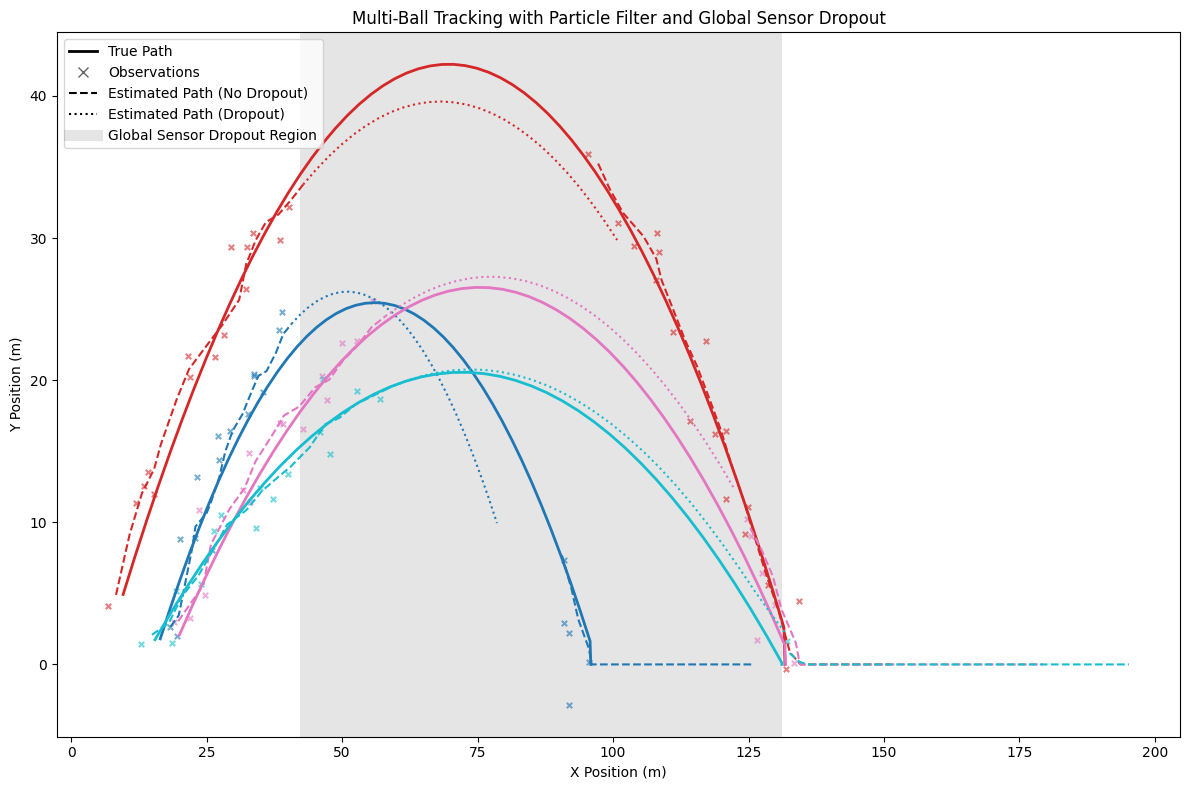

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

# Constants

g = 9.81  # Acceleration due to gravity (m/s^2).
dt = 0.1  # Time step (seconds).
num_particles = 1000 # The number of particles
num_steps = 100 # The maximum number of time steps
noise_std = 2.0 # Standard deviation of observation noise (meters).



# Ball Class: Our Flying Object
# -------------------------------
# This class defines a single projectile. It calculates its true trajectory and generates realistic, noisy observations
class Ball:
    def __init__(self, x0, y0, v0, angle_deg):
        # Store the initial conditions given when creating a new ball.
        self.x0 = x0  # Starting horizontal position.
        self.y0 = y0  # Starting vertical position.
        self.v0 = v0  # Initial launch speed.
        self.angle_deg = angle_deg # Launch angle in degrees.

        # Convert the launch angle from degrees to radians.
        self.angle_rad = np.deg2rad(angle_deg)

        # Calculate the initial horizontal and vertical components of the velocity.
        self.vx0 = v0 * np.cos(self.angle_rad)
        self.vy0 = v0 * np.sin(self.angle_rad)

        # Simulate the ball's perfect, true flight path without any sensor errors.
        self.x_true, self.y_true = self._simulate_trajectory()

        # Create the "observed" trajectory by adding noise to the true path.
        self.x_obs, self.y_obs = self._add_noise()

    def _simulate_trajectory(self):
        # Initialize lists to store the x and y coordinates of the ball over time.
        x, y = [self.x0], [self.y0]
        # Set the current velocities to their initial values.
        vx, vy = self.vx0, self.vy0

        # Loop through each time step to calculate the ball's path.
        for _ in range(num_steps):
            vy -= g * dt  # Gravity constantly reduces the vertical velocity.
            x_new = x[-1] + vx * dt # Horizontal position updates based on constant horizontal velocity.
            y_new = y[-1] + vy * dt # Vertical position updates based on current vertical velocity.

            if y_new < 0:
                # If the ball tries to go below ground (y=0).
                if y[-1] > 0: # Ensure we only interpolate if the previous point was above ground.
                    # Interpolate to find the *exact* point where it hits the ground.

                    fraction = -y[-1] / (vy - g * dt) # Calculate the fraction of dt until ground hit.
                    x_new = x[-1] + vx * dt * fraction # Adjust x to the ground hit point.
                y_new = 0.0 # Force the y-coordinate to be exactly 0.
                x.append(x_new) # Add the final x-position.
                y.append(y_new) # Add the final y-position.
                break # Stop simulating this ball's trajectory, it has landed.

            x.append(x_new) # Add the new x-position to the trajectory.
            y.append(y_new) # Add the new y-position to the trajectory.

        # Convert the lists of coordinates to NumPy arrays.
        return np.array(x), np.array(y)

    def _add_noise(self):
        # Ensure the noisy observation array has the same length as the true trajectory.
        len_true = len(self.x_true)
        # Add random noise (from a normal distribution) to the true x and y positions.
        x_obs = self.x_true + np.random.normal(0, noise_std, size=len_true)
        y_obs = self.y_true + np.random.normal(0, noise_std, size=len_true)
        return x_obs, y_obs # Return the noisy observed positions.



# Particle Filter
# -------------------------------
# This class implements a particle filter.
class ParticleFilter:
    def __init__(self, num_particles, x0_range, y0_range, vx_range, vy_range, n_clusters=1):
        self.n = num_particles # Store the number of particles.
        self.n_clusters = n_clusters # How many distinct objects K-Means should try to find.


        # Initialize particles: each particle is a "hypothesis" about the ball's current state (x, y, vx, vy).
        # They are initially spread randomly within a specified range around the ball's initial state.
        self.particles = self._init_particles(x0_range, y0_range, vx_range, vy_range)

        # Initialize weights: initially, all particles are equally likely.
        self.weights = np.ones(self.n) / self.n

        # Store the last estimated position. This is useful as a fallback if the filter temporarily loses track or K-Means fails
        self.last_estimated_pos = np.array([(x0_range[0] + x0_range[1]) / 2, (y0_range[0] + y0_range[1]) / 2])

    def _init_particles(self, x0_range, y0_range, vx_range, vy_range):
        p = np.empty((self.n, 4)) # Create an empty NumPy array to hold all particle states: [x, y, vx, vy].
        # Fill each column with random uniform values within its specified range.
        p[:, 0] = np.random.uniform(*x0_range, size=self.n)  # Initial guesses for x position.
        p[:, 1] = np.random.uniform(*y0_range, size=self.n)  # Initial guesses for y position.
        p[:, 2] = np.random.uniform(*vx_range, size=self.n)  # Initial guesses for x-velocity.
        p[:, 3] = np.random.uniform(*vy_range, size=self.n)  # Initial guesses for y-velocity.
        return p

    def predict(self):
        # This is the "motion model" step. We advance each particle's state forward in time based on physics
        self.particles[:, 0] += self.particles[:, 2] * dt # Update x-position: x_new = x_old + vx * dt.
        self.particles[:, 1] += self.particles[:, 3] * dt # Update y-position: y_new = y_old + vy * dt.
        self.particles[:, 3] -= g * dt # Update y-velocity: vy_new = vy_old - g * dt.

        """Add a bit of "process noise" (diffusion) to the particles. This helps prevent all
           particles from converging too quickly and losing diversity, allowing the filter
           to track slight deviations or recover from errors."""

        process_noise_std_pos = 0.1 # Small noise for particle positions.
        process_noise_std_vel = 0.05 # Small noise for particle velocities.
        self.particles[:, 0] += np.random.normal(0, process_noise_std_pos, self.n)
        self.particles[:, 1] += np.random.normal(0, process_noise_std_pos, self.n)
        self.particles[:, 2] += np.random.normal(0, process_noise_std_vel, self.n)
        self.particles[:, 3] += np.random.normal(0, process_noise_std_vel, self.n)

        # Ensure particles don't "fall through the floor".
        self.particles[self.particles[:, 1] < 0, 1] = 0.0

    def update(self, observations):
        # This is the "measurement update" step. We compare each particle's predicted position to the actual sensor observation received.

        # If no observations are provided, we simply skip the weight update. The particles will continue to propagate based on their motion model.
        if len(observations) == 0:
            return

        # In this specific setup, `observations` is expected to be a single `[x_obs, y_obs]` measurement.
        if len(observations) == 2 and isinstance(observations, (list, np.ndarray)):
            current_observation = np.array(observations)
            # Calculate the Euclidean distance between each particle's position (x, y) and the current observation.
            distances = np.linalg.norm(self.particles[:, :2] - current_observation, axis=1)

            """Update particle weights: Particles that are closer to the observation
              receive higher weights, meaning they are more likely to represent the true state.
              We use a Gaussian-like likelihood function. The `noise_std` from constants is key here."""

            self.weights = np.exp(-distances**2 / (2 * noise_std**2)) # Formula for Gaussian likelihood.
            self.weights += 1.e-300 # Add a tiny value to prevent weights from becoming exactly zero,

            self.weights /= np.sum(self.weights) # Normalize weights so they sum up to 1.
        else:
            # This case handles unexpected observation formats.
            pass

    def resample(self):
        """Resampling addresses the problem of "degeneracy" in particle filters,
          where only a few particles might end up having significant weights.
          We create a new set of particles by picking from the current set, but with a
          probability proportional to their weights. Particles with higher weights are
          more likely to be duplicated, while low-weight particles are effectively eliminated."""

        N = self.n # Total number of particles.
        weights_sum = np.sum(self.weights)

        if weights_sum < 1e-10: # Check if all weights have essentially collapsed to zero.
            self.weights.fill(1.0 / N) # If so, reset all weights to uniform to try and recover.
        else:
            self.weights /= weights_sum # Normalize weights to sum to 1 (if not already).

        # Systematic Resampling: A more stable and efficient resampling method than simple random sampling.
        # It ensures that high-weight particles contribute proportionally to the new set.
        positions = (np.arange(N) + np.random.rand()) / N # Create N evenly spaced random numbers.
        indices = np.zeros(N, dtype=int) # Array to store the indices of particles to keep.
        cumulative_sum = np.cumsum(self.weights) # Calculate cumulative sum of weights.
        i, j = 0, 0
        while i < N: # Iterate through target positions.
            if positions[i] < cumulative_sum[j]: # If current target position falls within this particle's cumulative weight.
                indices[i] = j # Select this particle.
                i += 1
            else:
                j += 1 # Move to the next particle's cumulative weight.

        self.particles = self.particles[indices] # Replace the old set of particles with the newly selected ones.
        self.weights.fill(1.0 / N) # Reset all new particles to have equal weights; they are now all equally "good".

    def estimate_clusters(self):
        """This function uses K-Means clustering to find the "center(s)" of the particle cloud(s).
          This provides our best estimate(s) of the object's position(s)."""

        # Fallback 1: If all weights are effectively zero (filter "collapsed"),
        # or if there are too few unique particles for K-Means to form distinct clusters,
        # or if we are only looking for one cluster (n_clusters=1),
        # we compute the weighted mean of all particles as the estimate.
        if np.sum(self.weights) < 1e-10: # Check for weight collapse (very unlikely particles match observations).
            mean_pos = np.mean(self.particles[:, :2], axis=0) # Calculate simple mean of particle positions.
            self.last_estimated_pos = mean_pos # Update our last known good estimate.
            return np.array([mean_pos] * self.n_clusters) # Return multiple copies if n_clusters > 1.

        unique_particles_pos = np.unique(self.particles[:, :2], axis=0) # Get unique particle positions.

        # Fallback 2: If K-Means can't meaningfully form `n_clusters` (e.g., trying to find 2 clusters from 1 unique point),
        # or if we explicitly only want 1 cluster, just return the weighted mean.
        if self.n_clusters > len(unique_particles_pos) or self.n_clusters == 1:
            weighted_mean_pos = np.average(self.particles[:, :2], axis=0, weights=self.weights) # Calculate weighted mean.
            self.last_estimated_pos = weighted_mean_pos # Update last known estimate.
            return np.array([weighted_mean_pos] * self.n_clusters) # Return 'n_clusters' copies of the weighted mean.

        try:
            # Attempt to run K-Means clustering on the particle positions, weighted by their current likelihood.
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=42) # Initialize K-Means. `n_init=10` runs it 10 times with different centroids and picks the best.
            kmeans.fit(self.particles[:, :2], sample_weight=self.weights) # Fit K-Means, considering particle weights.

            # Store the estimated position(s). If n_clusters is 1, store just that one center.
            self.last_estimated_pos = kmeans.cluster_centers_[0] if self.n_clusters == 1 else kmeans.cluster_centers_
            return kmeans.cluster_centers_ # Return the coordinates of the cluster centers (our best estimates).
        except Exception as e:
            # If K-Means fails for any reason,fall back to using the weighted mean as the estimate.
            weighted_mean_pos = np.average(self.particles[:, :2], axis=0, weights=self.weights)
            self.last_estimated_pos = weighted_mean_pos
            return np.array([weighted_mean_pos] * self.n_clusters) # Return copies of the weighted mean as fallback.




# Simulator
# -------------------------------
# This class sets up and runs the entire simulation.
class Simulator:
    def __init__(self, n_balls, n_clusters=1, dropout_probability=0.5, dropout_duration_steps_min=10, dropout_duration_steps_max=30):
        self.n_balls = n_balls # Number of independent balls to track.
        self.n_clusters = n_clusters # Number of clusters K-Means should try to find per particle filter.
        self.balls = [] # List to hold all the `Ball` objects.
        # Initialize an empty list of lists to store estimated trajectories for each ball.
        self.estimates_all = [[] for _ in range(n_balls)]

        # Parameters for simulating a "global sensor dropout".
        self.global_dropout_interval = None # This will store (start_time_step, end_time_step) for dropout.
        self.dropout_probability = dropout_probability # Chance that a dropout will occur in a simulation run.
        self.dropout_duration_steps_min = dropout_duration_steps_min # Minimum steps for a dropout.
        self.dropout_duration_steps_max = dropout_duration_steps_max # Maximum steps for a dropout.

    def _generate_global_dropout_interval(self, max_timesteps):
        # Decide if a global sensor dropout event will happen.
        if np.random.rand() < self.dropout_probability:
            # Determine a reasonable starting point for the dropout, not too early or too late.
            min_start_t = int(max_timesteps * 0.1)
            max_possible_start_t = max_timesteps - self.dropout_duration_steps_min - 1

            if max_possible_start_t <= min_start_t:
                # If the trajectory is too short to fit a dropout, then no dropout.
                return

            # Randomly select the start time and duration of the dropout.
            start_t = np.random.randint(min_start_t, max_possible_start_t + 1)
            duration = np.random.randint(self.dropout_duration_steps_min, self.dropout_duration_steps_max + 1)
            end_t = min(start_t + duration, max_timesteps - 1) # Ensure dropout doesn't exceed trajectory length.

            self.global_dropout_interval = (start_t, end_t)
            print(f"Global sensor dropout: from step {start_t} to {end_t} (Time: {start_t*dt:.1f}s to {end_t*dt:.1f}s)")

    def run(self):

        temp_balls = []
        for _ in range(self.n_balls):
            temp_balls.append(Ball(
                x0=np.random.uniform(5, 20), y0=np.random.uniform(0, 5),
                v0=np.random.uniform(20, 40), angle_deg=np.random.uniform(30, 60)
            ))
        max_timesteps = max(len(ball.x_obs) for ball in temp_balls) if temp_balls else num_steps

        # Now, generate the global dropout interval based on the maximum trajectory length.
        self._generate_global_dropout_interval(max_timesteps)

        self.balls = [] # Reset the balls list, as temp_balls were just for length calculation.
        particle_filters = [] # This list will hold a separate ParticleFilter instance for each ball.

        # Initialize each ball and its corresponding Particle Filter.
        for i in range(self.n_balls):
            # Generate random initial conditions for each new ball.
            x0 = np.random.uniform(5, 20)
            y0 = np.random.uniform(0, 5)
            v0 = np.random.uniform(20, 40)
            angle = np.random.uniform(30, 60)
            ball = Ball(x0, y0, v0, angle) # Create the ball object.
            self.balls.append(ball) # Add it to our list of simulated balls.

            """Create a ParticleFilter instance specifically for tracking this ball.
              The initial ranges for particles are centered around the ball's true initial state,
              with some spread to allow the filter to explore possibilities."""
            pf = ParticleFilter(
                num_particles,
                x0_range=(x0 - 5, x0 + 5),
                y0_range=(y0 - 5, y0 + 5),
                vx_range=(ball.vx0 - 5, ball.vx0 + 5),
                vy_range=(ball.vy0 - 5, ball.vy0 + 5),
                n_clusters=self.n_clusters # Tell this PF how many clusters (objects) to look for.
            )
            particle_filters.append(pf) # Add the PF to our list.

        # Main Simulation Loop
        # Iterate through each time step, applying prediction, update, and resampling for each ball.
        for t in range(max_timesteps):
            is_global_dropout_active = False # Flag to check if global sensor dropout is currently active.
            if self.global_dropout_interval:
                start_t_dropout, end_t_dropout = self.global_dropout_interval
                if start_t_dropout <= t <= end_t_dropout:
                    is_global_dropout_active = True

            for i, ball in enumerate(self.balls):
                pf = particle_filters[i] # Get the particle filter for the current ball.
                pf.predict() # Step 1: Predict the next state of all particles based on the motion model.

                current_obs_for_this_ball = [] # Initialize an empty list for current observation.
                if not is_global_dropout_active:
                    # If no dropout, and the ball is still in the air (has observations):
                    if t < len(ball.x_obs):
                        current_obs_for_this_ball = [ball.x_obs[t], ball.y_obs[t]]
                    # If no dropout, but the ball has already landed:
                    elif t >= len(ball.x_obs):
                        # After landing, we consider the observation to be its final landing spot (noiseless).
                        current_obs_for_this_ball = [ball.x_true[-1], 0.0]

                # Step 2: Update particle weights based on observations.
                # If `current_obs_for_this_ball` is empty (during dropout), the weights won't change,
                # meaning the filter relies purely on its prediction model.
                pf.update(current_obs_for_this_ball)

                # Step 3: Estimate the ball's position(s) by clustering the particles.
                # Even during dropout, this will return an estimate based on the current particle distribution.
                centers = pf.estimate_clusters()
                self.estimates_all[i].append(centers) # Store the estimated center(s) for this ball.

                pf.resample() # Step 4: Resample particles to concentrate on high-likelihood areas and maintain diversity.

    def plot(self):
        plt.figure(figsize=(12, 8)) # Create a figure with a specific size for better readability.
        colors = plt.cm.get_cmap('tab10', self.n_balls) # Use a colormap for distinct colors for each ball.

        # Flags to ensure certain legend entries only appear once, even if multiple balls contribute to them.
        has_labeled_dropout_segment = False
        has_labeled_dropout_region = False

        # Calculate and Plot Global Sensor Dropout Region
        # This section calculates the bounding box for where the sensor dropout occurs to draw a shaded background indicating this period.
        min_x_dropout, max_x_dropout = float('inf'), float('-inf')
        min_y_dropout, max_y_dropout = float('inf'), float('-inf')

        if self.global_dropout_interval:
            start_t_dropout, end_t_dropout = self.global_dropout_interval
            for ball in self.balls:
                # Ensure time steps are within the bounds of the ball's actual trajectory length.
                safe_start_t = min(start_t_dropout, len(ball.x_true) - 1)
                safe_end_t = min(end_t_dropout, len(ball.x_true) - 1)

                if safe_start_t <= safe_end_t: # Make sure the range is valid.
                    # Get the true x and y positions of the ball during the dropout interval.
                    current_ball_x = ball.x_true[safe_start_t : safe_end_t + 1]
                    current_ball_y = ball.y_true[safe_start_t : safe_end_t + 1]
                    if len(current_ball_x) > 0: # Only if there are points in this segment.
                        # Expand the min/max bounds to encompass all ball trajectories during dropout.
                        min_x_dropout = min(min_x_dropout, np.min(current_ball_x))
                        max_x_dropout = max(max_x_dropout, np.max(current_ball_x))
                        min_y_dropout = min(min_y_dropout, np.min(current_ball_y))
                        max_y_dropout = max(max_y_dropout, np.max(current_ball_y))


        # If a valid dropout range was found, add the shaded vertical span to the plot.
        if min_x_dropout != float('inf') and self.global_dropout_interval:
            plt.axvspan(min_x_dropout, max_x_dropout, color='gray', alpha=0.2, lw=0, label='Global Sensor Dropout')
            has_labeled_dropout_region = True # Mark that this legend entry has been added.

        # Plot Trajectories and Observations for Each Ball
        for i, ball in enumerate(self.balls):
            color = colors(i) # Get a distinct color for this ball.

            # Plot the True Path of the ball.
            plt.plot(ball.x_true, ball.y_true, color=color, linestyle='-', linewidth=2, label=f"Ball {i+1} True Path")

            # Plot Observations (only when not in dropout).
            valid_obs_x = []
            valid_obs_y = []
            for t_step in range(len(ball.x_obs)):
                is_global_dropout_active_at_t = False
                if self.global_dropout_interval:
                    start_t_dropout, end_t_dropout = self.global_dropout_interval
                    if start_t_dropout <= t_step <= end_t_dropout:
                        is_global_dropout_active_at_t = True

                if not is_global_dropout_active_at_t:
                    valid_obs_x.append(ball.x_obs[t_step])
                    valid_obs_y.append(ball.y_obs[t_step])
            plt.scatter(valid_obs_x, valid_obs_y, color=color, s=15, marker='x', alpha=0.6, label=f"Ball {i+1} Observations")

            # Plot Estimated Trajectory, differentiating between dropout and non-dropout periods.
            estimates_for_ball = np.array(self.estimates_all[i])
            # Assuming n_clusters is 1, so `estimates_for_ball[:, 0, :]` gives the [x, y] estimates over time.

            if self.global_dropout_interval:
                start_t_dropout, end_t_dropout = self.global_dropout_interval

                # Segment of estimated path *before* the dropout.
                if start_t_dropout > 0:
                    plt.plot(estimates_for_ball[:start_t_dropout+1, 0, 0], estimates_for_ball[:start_t_dropout+1, 0, 1],
                             color=color, linestyle='--', linewidth=1.5)

                # Segment of estimated path *during* the dropout (different linestyle).
                actual_end_t_dropout = min(end_t_dropout, len(estimates_for_ball) - 1)
                if start_t_dropout <= actual_end_t_dropout:
                    dropout_segment_estimates = estimates_for_ball[start_t_dropout:actual_end_t_dropout+1, 0, :]
                    # Only label this segment once for the legend.
                    label_dropout_segment = 'Estimated Path (Dropout)' if not has_labeled_dropout_segment else None
                    plt.plot(dropout_segment_estimates[:, 0], dropout_segment_estimates[:, 1],
                             color=color, linestyle=':', linewidth=1.5, label=label_dropout_segment)
                    has_labeled_dropout_segment = True

                # Segment of estimated path *after* the dropout.
                if actual_end_t_dropout + 1 < len(estimates_for_ball):
                    plt.plot(estimates_for_ball[actual_end_t_dropout+1:, 0, 0], estimates_for_ball[actual_end_t_dropout+1:, 0, 1],
                             color=color, linestyle='--', linewidth=1.5)
            else:
                # If there's no global dropout, plot the entire estimated trajectory with a single linestyle.
                plt.plot(estimates_for_ball[:, 0, 0], estimates_for_ball[:, 0, 1],
                         color=color, linestyle='--', linewidth=1.5, label=f"Ball {i+1} Estimated Path")

        plt.xlabel("X Position (m)")
        plt.ylabel("Y Position (m)")
        plt.title("Multi-Ball Tracking with Particle Filter and Global Sensor Dropout")



        # Since we have multiple balls and specific line styles, a custom legend is necessary to avoid repeating labels for each ball.
        custom_lines = [
            Line2D([0], [0], color='black', lw=2, linestyle='-'),                 # For True Path
            Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=7, alpha=0.6), # For Observations
            Line2D([0], [0], color='black', lw=1.5, linestyle='--'),             # For Estimated Path (No Dropout)
            Line2D([0], [0], color='black', lw=1.5, linestyle=':')              # For Estimated Path (Dropout)
        ]
        labels = ['True Path', 'Observations', 'Estimated Path (No Dropout)', 'Estimated Path (Dropout)']

        # Add the dropout region to the legend only if it was drawn.
        if has_labeled_dropout_region:
            custom_lines.append(Line2D([0], [0], color='gray', lw=8, alpha=0.2)) # A thick, transparent line to represent the shaded area.
            labels.append('Global Sensor Dropout Region')

        plt.legend(custom_lines, labels, loc='upper left') # Display the custom legend in the upper left corner.
        plt.tight_layout() # Adjust plot parameters for a tight layout, preventing labels from overlapping.
        plt.show() # Display the final plot!

# -------------------------------
# Run the Simulation: Let's See It In Action!
# -------------------------------
if __name__ == "__main__":

    sim = Simulator(n_balls=4, n_clusters=1, dropout_probability=0.8, dropout_duration_steps_min=15, dropout_duration_steps_max=40)
    sim.run() # Start the simulation, generate data, and run the particle filters.
    sim.plot() # Visualize the results, showing how the filter performs with and without observations.